In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, ttest_ind
from sklearn.decomposition import PCA

from matplotlib_venn import venn2



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install gseapy
!pip install adjustText
import gseapy as gp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
#Data was filtered on the basis of NaN on peptide sequences
file_path = '/content/drive/My Drive/440_Project/peptide_filtered_data_all_samples_2.xlsx'  # replace with actual path
excel_file = pd.ExcelFile(file_path)

#TNBC Samples with lymph node spread
N_spread_labels = ['Sample_333','Sample_2339','Sample_977','Sample_825','Sample_2060','Sample_1097','Sample_1949']

#TNBC Samples with no lymph node spread (2189, 513, 1478, 1137, 2049)
NLN_spread_labels = ['Sample_2189','Sample_513','Sample_1478','Sample_1137','Sample_2049']

# Dict to store dataframes
all_samples = {}

# Iterate through each sheet in the Excel file
for sheet_name in excel_file.sheet_names:
    # Read the specific columns (replace 'Column1', 'Column2', 'Column3' with your actual column names)
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    # Add the dataframe to the dictionary with the sheet name as the key
    all_samples[sheet_name] = df


In [ ]:
all_samples['Sample_1137']

,Unnamed: 0,Peptide sequence,Total ion current,Score,q-value,Protein accessions / positions,NetMHCpan-4.1b affinity: HLA-A*03:01,NetMHCpan-4.1b affinity: HLA-A*25:01,NetMHCpan-4.1b affinity: HLA-B*18:01,NetMHCpan-4.1b affinity: HLA-B*35:01,NetMHCpan-4.1b affinity: HLA-C*04:01,NetMHCpan-4.1b affinity: HLA-C*12:03,NetMHCpan-4.1b rank: HLA-A*03:01,NetMHCpan-4.1b rank: HLA-A*25:01,Source Protein
0,0,AAAAAQSVY,200000,22.47,0.00077,ENSG00000233276,5789.91,10992.60,9127.23,42.30,20630.50,49.73,4.939,1.836,GPX1
1,1,AAAALVLKA,254000,23.44,0.00045,ENSG00000137076,21181.71,35509.27,28760.80,18826.54,31494.15,1091.46,17.746,22.005,TLN1
2,2,AAADIFKHY,513000,25.60,0.00029,ENSG00000118007,9445.30,6690.15,6575.76,277.24,24198.92,18.24,7.081,0.977,STAG1
3,3,AAADSIKIW,402000,17.35,0.00220,ENSG00000065183,35234.84,9334.06,26596.96,12465.95,30883.71,947.05,53.162,1.484,WDR3
4,4,AAAKPTPPK,658000,19.75,0.00087,ENSG00000159140,59.68,32594.87,33829.46,20790.04,25889.69,7617.45,0.240,16.235,SON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,5236,YVYFTNELK,197000,18.83,0.00120,ENSG00000121858,73.86,21529.46,27981.75,17681.77,23701.91,8577.44,0.291,5.583,TNFSF10
5230,5237,YYDEIINAL,362000,27.34,0.00000,ENSG00000196576,33834.21,17064.53,9767.06,1913.97,58.07,533.69,47.623,3.587,PLXNB2
5231,5238,YYDGKVMKL,741000,16.33,0.00300,ENSG00000198900,31786.51,27003.50,24099.38,12280.68,112.66,2292.27,40.578,9.345,TOP1
5232,5239,YYDLQEVLL,273000,30.38,0.00000,ENSG00000107290,35034.52,35305.83,24300.20,11454.84,80.13,7514.22,52.361,21.563,SETX


In [ ]:
##
##
#### Function counts the number of unique proteins that are shared by at least two samples within each phenotype (Metastatic vs Non-metastatic)
from collections import Counter

def count_shared_elements(list_of_sets, num_sets_shared):
    element_counts = Counter()

    # Count how many sets each element appears in
    for s in list_of_sets:
        for elem in s:
            element_counts[elem] += 1

    # Count elements that appear in at least num_sets_shared sets
    shared_elements = [elem for elem, count in element_counts.items() if count > num_sets_shared-1]

    return shared_elements, len(shared_elements)


def find_group_specific_proteins(
    group_a_samples,
    group_b_samples,
    min_in_group_a,
    max_in_group_b
):
    """
    Identify proteins shared in at least `min_in_group_a` samples from group A
    and in at most `max_in_group_b` samples from group B.

    Parameters:
    - group_a_samples: list of sets (e.g., metastatic samples)
    - group_b_samples: list of sets (e.g., non-metastatic samples)
    - min_in_group_a: minimum number of group A samples a protein must be in
    - max_in_group_b: maximum number of group B samples a protein can be in

    Returns:
    - A set of proteins specific to group A based on given thresholds
    """

    group_a_counts = Counter(p for s in group_a_samples for p in s)
    group_b_counts = Counter(p for s in group_b_samples for p in s)

    specific_proteins = {
        protein for protein, count in group_a_counts.items()
        if count >= min_in_group_a and group_b_counts.get(protein, 0) <= max_in_group_b
    }

    return specific_proteins

##
##


In [ ]:
# Number of proteins shared across all datasets:
# Function to get the proteins sequences as a set
def get_protein_set(sheet_names):
    protein_sets = []
    for sheet_name in sheet_names:
        df = all_samples[sheet_name]
        #display(df)
        protein_sets.append(set(df['Source Protein'].dropna()))  # Convert to set and drop NaN values
    return protein_sets

# Get protein sets for both groups A and B
protein_set_A = get_protein_set(N_spread_labels)
protein_set_B = get_protein_set(NLN_spread_labels)

total_detected_proteins_Nodespread = len(set.union(*protein_set_A))
total_detected_proteins_NonNodespread = len(set.union(*protein_set_B))

print("All detected proteins: ", len(set.union(*protein_set_A) | set.union(*protein_set_B)))

print(f"Total detected proteins across all lymph node-spread samples: {total_detected_proteins_Nodespread}")
print(f"Total detected proteins across all non-metastatic samples: {total_detected_proteins_NonNodespread}")

print("Total number of unique proteins shared by at least two samples within the metastatic phenotype:", count_shared_elements(protein_set_A,2)[1])
print("Total number of unique proteins shared by at least two samples within the non_metastatic_phenotype", count_shared_elements(protein_set_B, 2)[1])

proteins_shared_across_all = count_shared_elements(protein_set_A+protein_set_B,12)[0]
print("Proteins shared across all samples:", proteins_shared_across_all)

#convert list to dataframe to be exported (if choosing to run enrichment manually)
proteins_shared_across_all_df = pd.DataFrame(proteins_shared_across_all, columns=['Protein'])
proteins_shared_across_all_df.to_excel('proteins_shared_across_all.xlsx')

# Find the intersection of protein sequences within the metastatic group
shared_proteins_within_A = set.intersection(*protein_set_A)
# Find the intersection of protein sequences within the non-metastatic group
shared_proteins_within_B = set.intersection(*protein_set_B)

# Output the results
if shared_proteins_within_A:
    print(f"Number of protein peptide sequences within lymph node-spread samples: {len(shared_proteins_within_A)}")
    print(f"The protein sequences shared are: {shared_proteins_within_A}")
else:
    print("No shared protein sequences within lymph node-spread samples.")

if shared_proteins_within_B:
    print(f"Number of shared protein sequences within non-metastatic samples: {len(shared_proteins_within_B)}")
    print(f"The protein sequences shared are: {shared_proteins_within_B}")
else:
    print("No shared protein sequences within non-metastatic samples.")

# Find the intersection between the two groups (common protein across both groups)
shared_proteins_between_groups = shared_proteins_within_A.intersection(shared_proteins_within_B)

# Count the number of shared protein sequences between the two groups
num_shared_proteins_between_groups = len(shared_proteins_between_groups)

# Output the result
print(f"Number of shared protein sequences between lymph metastatic and non-metastatic cells: {num_shared_proteins_between_groups}")

All detected proteins:  8415
Total detected proteins across all lymph node-spread samples: 6852
Total detected proteins across all non-metastatic samples: 6745
Total number of unique proteins shared by at least two samples within the metastatic phenotype: 4018
Total number of unique proteins shared by at least two samples within the non_metastatic_phenotype 4102
Proteins shared across all samples: ['PRPF8', 'DDX3X', 'PSMD2', 'MAP1B', 'CYBB', 'SF3B1', 'CTNNA1', 'SUPT6H', 'COL6A2', 'HNRNPA0', 'ABCA1', 'BIRC6', 'ECPAS', 'SPTAN1', 'VPS13C', 'ATM', 'TKT', 'AHNAK', 'MYO1B', 'KIFAP3', 'ADD1', 'MDN1', 'RTCB', 'PLEC', 'HNRNPK', 'RPN1', 'MYO9B', 'UPF1', 'SFPQ', 'DDX24', 'UBR2', 'VCAN', 'DOCK10', 'TSC2', 'COPB2', 'INTS1', 'HLA-DPA1', 'HNRNPU', 'STAT1', 'FNDC3B', 'TLN1', 'EHD2', 'RNF213', 'PLXNB2', 'ANXA2', 'ATP6AP2', 'DYNC1H1', 'SAMHD1', 'MAGED2', 'FN1', 'IQGAP1', 'LMNA', 'PSMB9', 'FLNA', 'EPRS', 'ACTN4', 'VIM', 'MACF1', 'EEF2', 'QKI', 'STAT3', 'ITGAV', 'SOAT1', 'SPTBN1', 'ACTR2', 'EXOSC10', 'STA

# **GSEA on proteins shared across all samples**

In [ ]:
import os

def plot_enrichment_barplot(
    gene_list,
    gene_set='KEGG_2021_Human',
    organism='Human',
    title='Top Enriched Pathways',
    outdir='enrichr_results',
    fdr_cutoff=0.05,
    top_n=10,
    figsize=(9, 6),
    color='skyblue',
    title_size=18,
    labelsize=12,
    save_results_as=None
):
    """
    Perform pathway enrichment using Enrichr and plot top enriched terms.

    Parameters:
        gene_list (list): List of gene symbols.
        gene_set (str): Enrichr gene set library name (e.g., 'Reactome_2022', 'MSigDB_Hallmark_2020').
        organism (str): Organism name, typically 'Human' or 'Mouse'.
        title (str): Title for the plot.
        outdir (str): Output directory for enrichment results.
        fdr_cutoff (float): FDR threshold for filtering enriched terms.
        top_n (int): Number of top terms to plot.
        figsize (tuple): Size of the figure.
        color (str): Bar color for the plot.
        title_size (int): Title size for the plot.
        labelsize (int): Label size for the plot.
        save_results_as (str): If provided, saves the full enrichment results as CSV with this filename.


    """
    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=gene_set,
        organism=organism,
        outdir=outdir,
        cutoff=fdr_cutoff
    )

    df = enr.results.copy()
    if save_results_as:
        os.makedirs(outdir, exist_ok=True)
        filepath = os.path.join(outdir, f"{save_results_as}.csv")
        df.to_csv(filepath, index=False)
        print(f"Results saved to: {filepath}")



    df = df[df['Adjusted P-value'] < fdr_cutoff].sort_values('Adjusted P-value').head(top_n)
    if df.empty:
        print("No significant terms found with current FDR cutoff.")
        return

    df['-log10(adj p-value)'] = -np.log10(df['Adjusted P-value'])
    df['Term'] = df['Term'].str.replace(r' \(.*\)', '', regex=True)

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=df,
        x='-log10(adj p-value)',
        y='Term',
        color=color
    )
    plt.axvline(x=-np.log10(fdr_cutoff), color='red', linestyle='--', linewidth=1.5, label=f'FDR = {fdr_cutoff}')
    plt.xlabel('-log10(Adjusted P-value)', fontsize=14)
    plt.ylabel('')
    plt.title(title, fontsize=title_size)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    plt.tight_layout()
    plt.show()


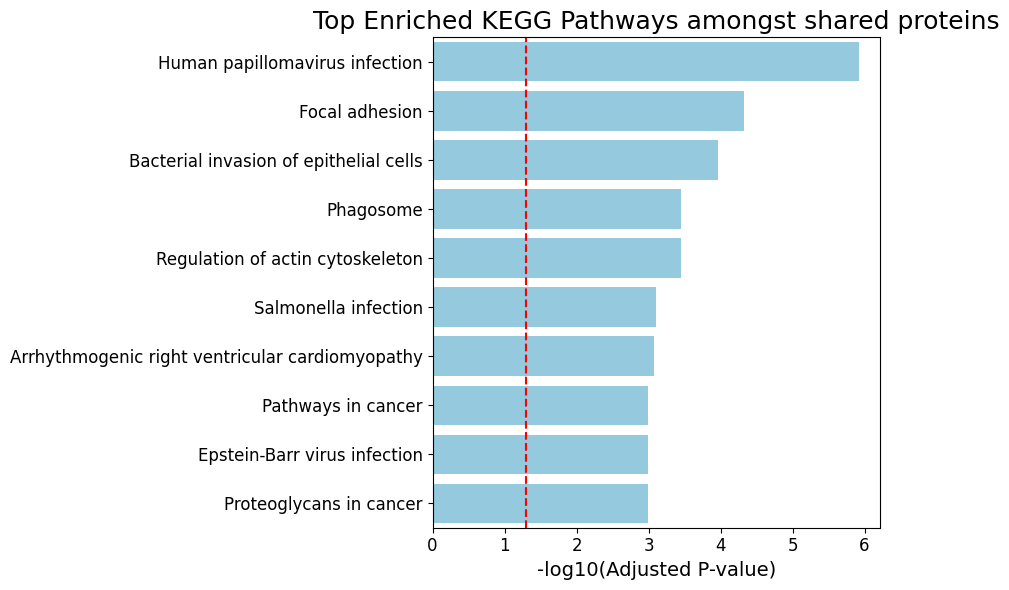

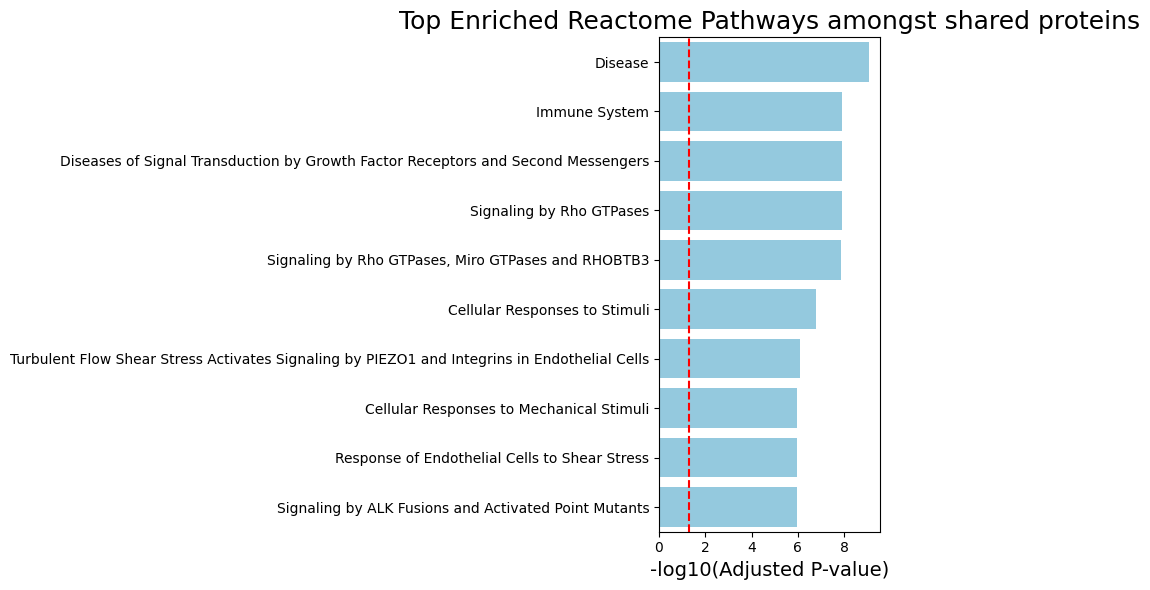

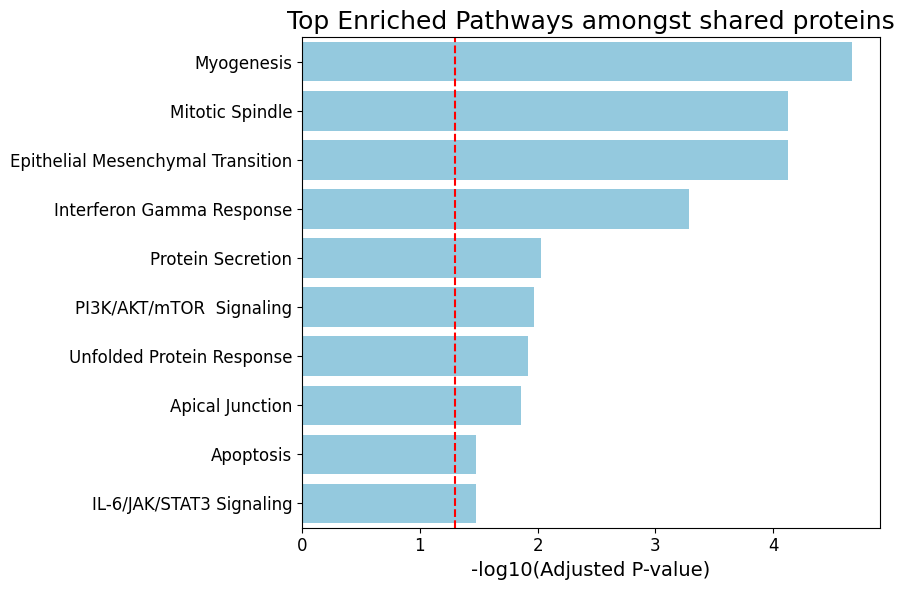

In [ ]:
plot_enrichment_barplot(
    gene_list=proteins_shared_across_all,
    gene_set='KEGG_2021_Human',
    title='Top Enriched KEGG Pathways amongst shared proteins'
)

plot_enrichment_barplot(
    gene_list=proteins_shared_across_all,
    gene_set='Reactome_Pathways_2024',
    title='Top Enriched Reactome Pathways amongst shared proteins',
    labelsize=10
)

plot_enrichment_barplot(
    gene_list=proteins_shared_across_all,
    gene_set='MSigDB_Hallmark_2020',
    title='Top Enriched Pathways amongst shared proteins',
)

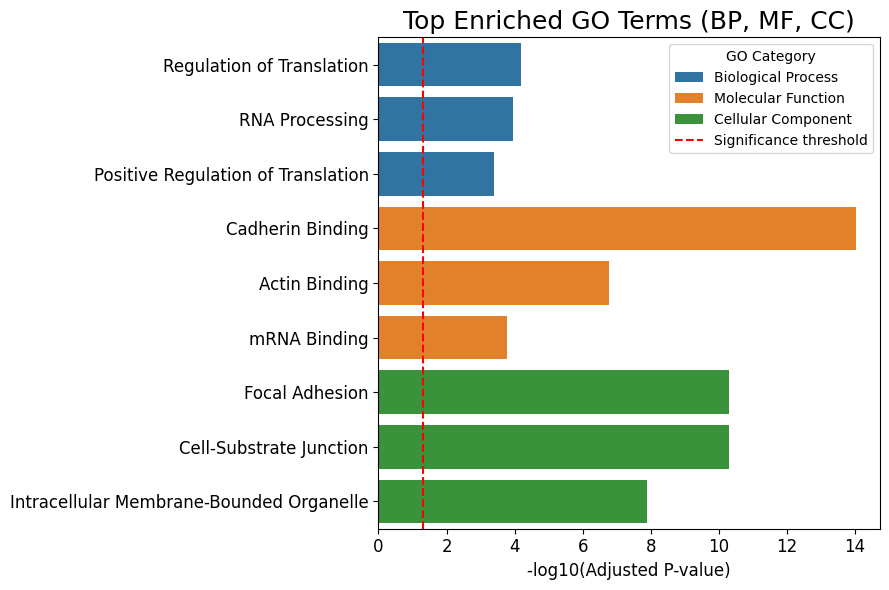

In [ ]:
go_bp = gp.enrichr(proteins_shared_across_all, gene_sets='GO_Biological_Process_2025', organism='Human', outdir=None)
go_mf = gp.enrichr(proteins_shared_across_all, gene_sets='GO_Molecular_Function_2025', organism='Human', outdir=None)
go_cc = gp.enrichr(proteins_shared_across_all, gene_sets='GO_Cellular_Component_2025', organism='Human', outdir=None)

# 3. Prepare and label top results from each
def prep_go_df(result, label, top_n):
    df = result.results.copy()
    df = df[df['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value').head(top_n)
    df['-log10(adj p-value)'] = -np.log10(df['Adjusted P-value'])
    df['GO Category'] = label
    df['Term'] = df['Term'].str.replace(r' \(.*\)', '', regex=True)
    return df[['Term', '-log10(adj p-value)', 'GO Category']]

df_bp = prep_go_df(go_bp, 'Biological Process', 3)
df_mf = prep_go_df(go_mf, 'Molecular Function', 3)
df_cc = prep_go_df(go_cc, 'Cellular Component', 3)

# 4. Combine into one DataFrame
combined_df = pd.concat([df_bp, df_mf, df_cc], ignore_index=True)

# 5. Plot
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=combined_df,
    x='-log10(adj p-value)',
    y='Term',
    hue='GO Category',
)

plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1.5, label='Significance threshold')

ax.tick_params(axis='x', labelsize=12) # Adjust labelsize as needed
ax.tick_params(axis='y', labelsize=12) # Adjust labelsize as needed

plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
plt.ylabel('')
plt.title('Top Enriched GO Terms (BP, MF, CC)', fontsize=18)
plt.legend(title='GO Category', loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
gp.get_library_name()[:]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

# **GSEA on protein sets found mostly in metastatic**

Number of proteins found mostly (>=4) in lymph node metastatic, and less so (<=2) in non-metastatic samples:  337
Number of proteins found mostly (>=4) in lymph node metastatic, and less so (<=1) in non-metastatic samples:  100
Number of proteins found mostly (>=5) in lymph node metastatic, and less so (<=2) in non-metastatic samples:  95
Number of proteins found mostly (>=5) in lymph node metastatic, and less so (<=1) in non-metastatic samples:  14
Number of proteins found mostly (>=6) in lymph node metastatic, and less so (<=1) in non-metastatic samples:  1
Number of proteins found mostly (>=6) in lymph node metastatic, and less so (<=2) in non-metastatic samples:  20
Number of proteins found mostly (>=7) in lymph node metastatic, and less so (<=1) in non-metastatic samples:  0


<ipython-input-101-d8ec7a87e0c1>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Threshold', y='Protein_Count', data=df, palette='viridis')


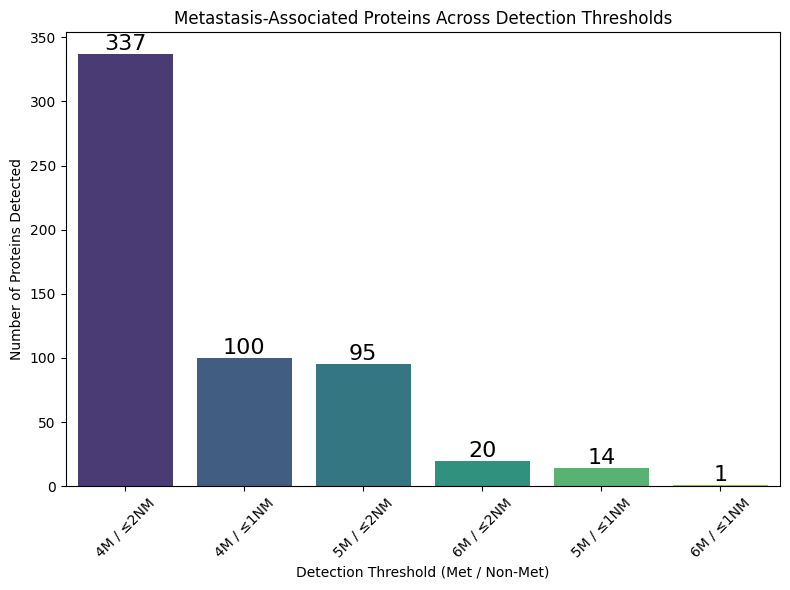

In [ ]:
specific_4to2_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 4, 2)
print("Number of proteins found mostly (>=4) in lymph node metastatic, and less so (<=2) in non-metastatic samples: ",
      len(specific_4to2_metastatic_proteins))

specific_4to1_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 4, 1)
print("Number of proteins found mostly (>=4) in lymph node metastatic, and less so (<=1) in non-metastatic samples: ",
      len(specific_4to1_metastatic_proteins))

specific_5to2_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 5, 2)
print("Number of proteins found mostly (>=5) in lymph node metastatic, and less so (<=2) in non-metastatic samples: ",
      len(specific_5to2_metastatic_proteins))

specific_5to1_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 5, 1)
print("Number of proteins found mostly (>=5) in lymph node metastatic, and less so (<=1) in non-metastatic samples: ",
      len(specific_5to1_metastatic_proteins))

specific_6to1_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 6, 1)
print("Number of proteins found mostly (>=6) in lymph node metastatic, and less so (<=1) in non-metastatic samples: ",
      len(specific_6to1_metastatic_proteins))

specific_6to2_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 6, 2)
print("Number of proteins found mostly (>=6) in lymph node metastatic, and less so (<=2) in non-metastatic samples: ",
      len(specific_6to2_metastatic_proteins))

specific_7to1_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 7, 1)
print("Number of proteins found mostly (>=7) in lymph node metastatic, and less so (<=1) in non-metastatic samples: ",
      len(specific_7to1_metastatic_proteins))

df = pd.DataFrame({
    'Met_Samples_≥': [4, 4, 5, 6, 5, 6],
    'NonMet_Samples_≤': [2, 1, 2, 2, 1, 1],
    'Protein_Count': [len(specific_4to2_metastatic_proteins),
                      len(specific_4to1_metastatic_proteins),
                      len(specific_5to2_metastatic_proteins),
                      len(specific_6to2_metastatic_proteins),
                      len(specific_5to1_metastatic_proteins),
                      len(specific_6to1_metastatic_proteins),]
})


# Make a label column for x-axis
df['Threshold'] = df['Met_Samples_≥'].astype(str) + 'M / ≤' + df['NonMet_Samples_≤'].astype(str) + 'NM'

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Threshold', y='Protein_Count', data=df, palette='viridis')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=16)

plt.xticks(rotation=45)
plt.title('Metastasis-Associated Proteins Across Detection Thresholds')
plt.ylabel('Number of Proteins Detected')
plt.xlabel('Detection Threshold (Met / Non-Met)')
plt.tight_layout()
plt.show()



In [ ]:
mostly_met_df = pd.DataFrame(specific_4to2_metastatic_proteins, columns=['Protein'])
mostly_met_df.to_excel('mostly_met_df.xlsx')

mostly_met_df = pd.DataFrame(specific_5to2_metastatic_proteins, columns=['Protein'])
mostly_met_df.to_excel('mostly_met_5_2df.xlsx')

mostly_met_df = pd.DataFrame(specific_5to1_metastatic_proteins, columns=['Protein'])
mostly_met_df.to_excel('mostly_met_5_1df.xlsx')


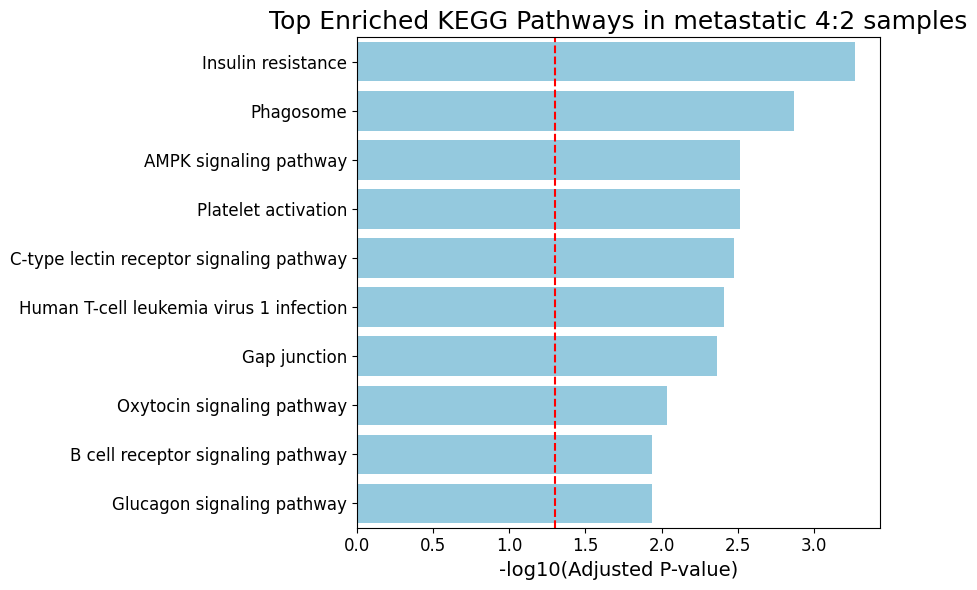

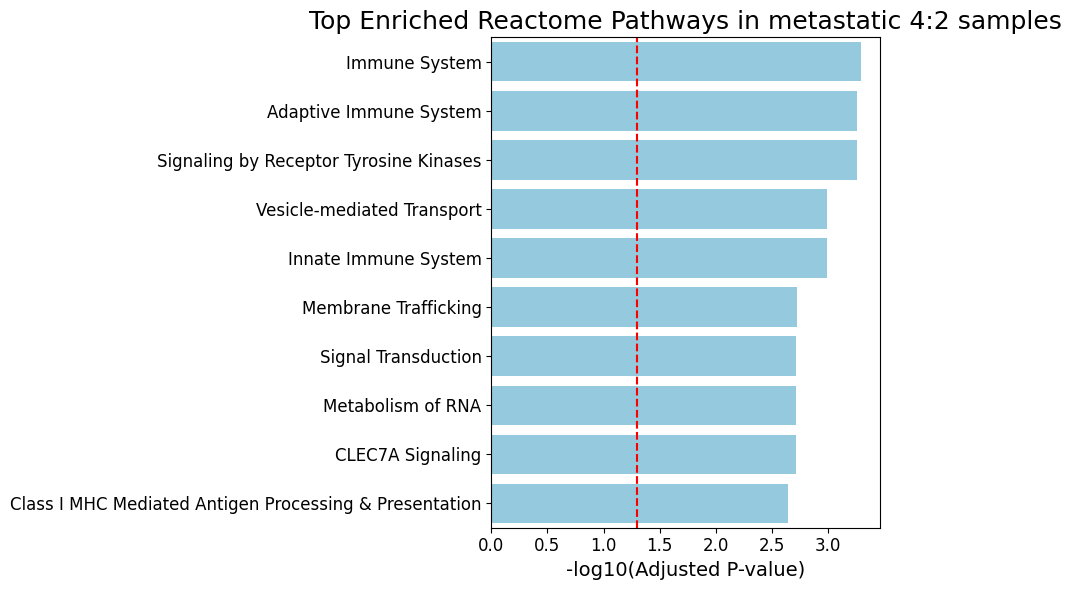

Results saved to: enrichr_results/MSigDB_Hallmark_2020_4to2.csv


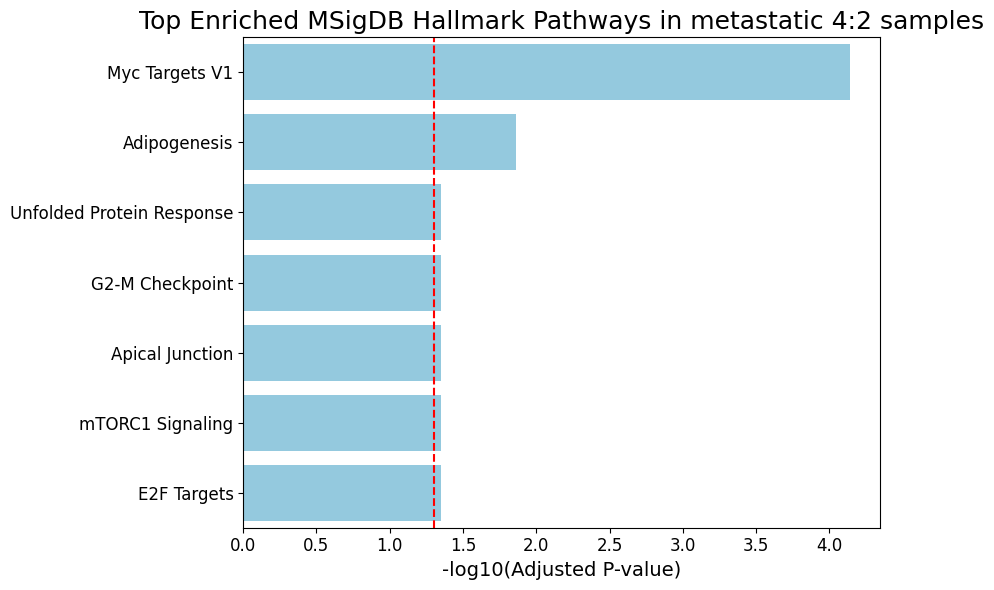

In [ ]:
plot_enrichment_barplot(
    gene_list=list(specific_4to2_metastatic_proteins),
    gene_set='KEGG_2021_Human',
    title='Top Enriched KEGG Pathways in metastatic 4:2 samples'
)
plot_enrichment_barplot(
    gene_list=list(specific_4to2_metastatic_proteins),
    gene_set='Reactome_Pathways_2024',
    title='Top Enriched Reactome Pathways in metastatic 4:2 samples'
)
plot_enrichment_barplot(
    gene_list=list(specific_4to2_metastatic_proteins),
    gene_set='MSigDB_Hallmark_2020',
    title='Top Enriched MSigDB Hallmark Pathways in metastatic 4:2 samples',
    save_results_as='MSigDB_Hallmark_2020_4to2'
)

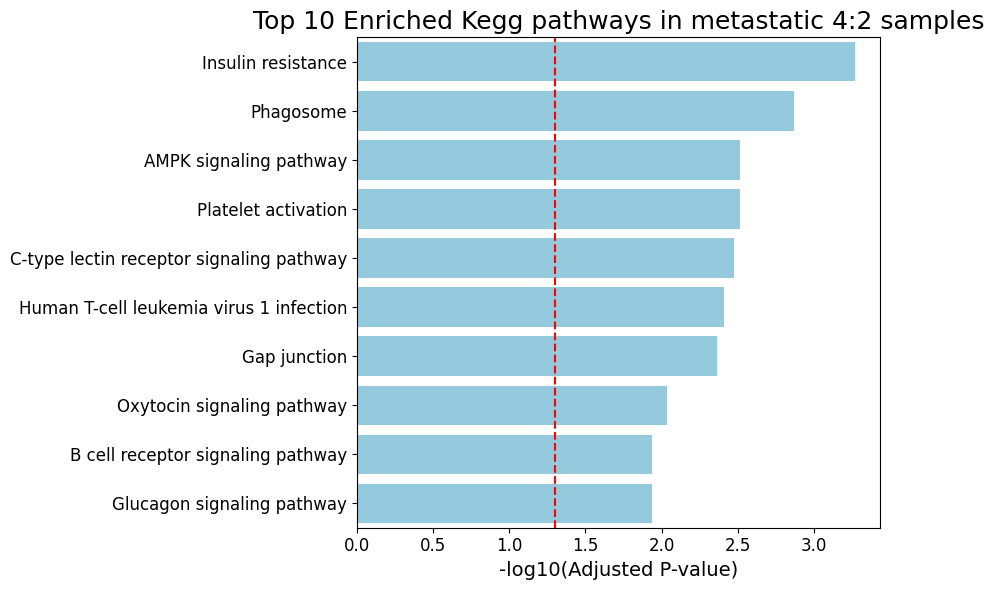

In [ ]:
enr = gp.enrichr(gene_list=list(specific_4to2_metastatic_proteins),
                 gene_sets='KEGG_2021_Human',
                 organism='Human',
                 outdir='enrichr_results',
                 cutoff=0.05)  # Adjust FDR cutoff

# Make SNS barplot manually
df = enr.results.copy()
df = df[df['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value').head(10)
df['-log10(adj p-value)'] = -np.log10(df['Adjusted P-value'])
df['Term'] = df['Term'].str.replace(r' \(.*\)', '', regex=True)

# Plot barplot
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=df,
    x='-log10(adj p-value)',
    y='Term',
    color='skyblue'
)
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1.5, label='FDR = 0.05')

ax.tick_params(axis='x', labelsize=12) # Adjust labelsize as needed
ax.tick_params(axis='y', labelsize=12) # Adjust labelsize as needed

plt.xlabel('-log10(Adjusted P-value)', fontsize=14)
plt.ylabel('')
plt.title('Top 10 Enriched Kegg pathways in metastatic 4:2 samples', fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
print(df[['Term', 'Adjusted P-value', 'Overlap', 'Genes']])

#print lists of all of the genes for each pathway:
for index, row in df.iterrows():
  print(row['Term'], row['Genes'])

                                       Term  Adjusted P-value Overlap  \
0                        Insulin resistance          0.000536  11/108   
1                                 Phagosome          0.001340  12/152   
2                    AMPK signaling pathway          0.003037  10/120   
3                       Platelet activation          0.003037  10/124   
4  C-type lectin receptor signaling pathway          0.003345   9/104   
5   Human T-cell leukemia virus 1 infection          0.003908  13/219   
6                              Gap junction          0.004291    8/88   
7                Oxytocin signaling pathway          0.009162  10/154   
8         B cell receptor signaling pathway          0.011559    7/81   
9                Glucagon signaling pathway          0.011559   8/107   

                                               Genes  
0  NFKBIA;PYGB;GYS1;PDPK1;CREB3L2;PRKCD;PRKAG1;IR...  
1  MRC2;TUBA1A;TUBB3;CANX;TAP2;CYBA;PIK3C3;CALR;C...  
2  GYS1;PDPK1;STRADA;SCD;CREB3L

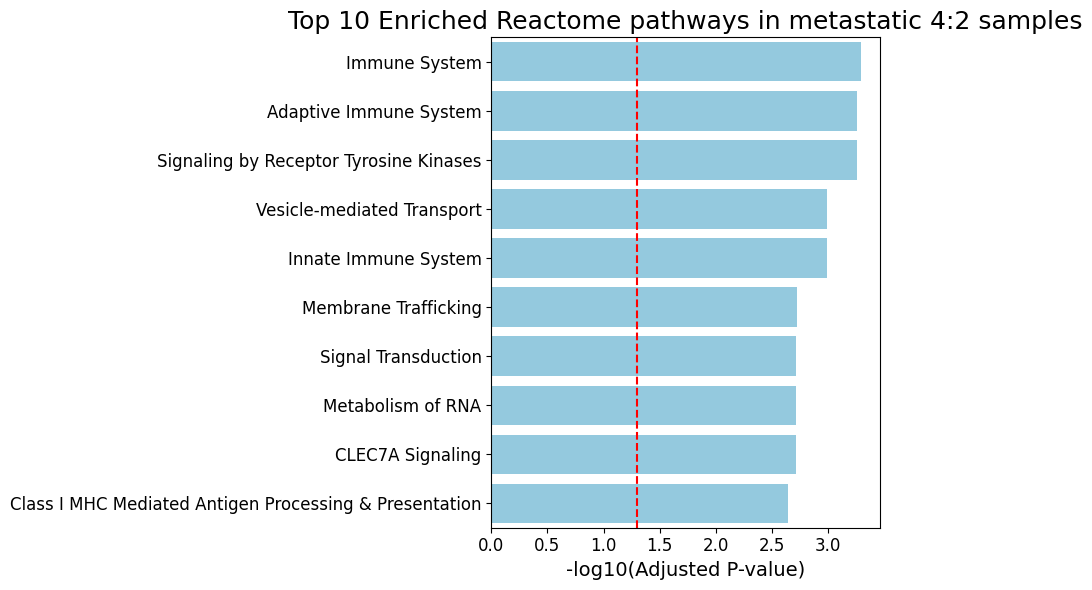

In [ ]:
enr = gp.enrichr(gene_list=list(specific_4to2_metastatic_proteins),
                 gene_sets='Reactome_Pathways_2024',
                 organism='Human',
                 outdir='enrichr_results',
                 cutoff=0.05)  # Adjust FDR cutoff

# Make SNS barplot manually
df = enr.results.copy()
df = df[df['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value').head(10)
df['-log10(adj p-value)'] = -np.log10(df['Adjusted P-value'])
df['Term'] = df['Term'].str.replace(r' \(.*\)', '', regex=True)

# Plot barplot
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=df,
    x='-log10(adj p-value)',
    y='Term',
    color='skyblue'
)
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1.5, label='FDR = 0.05')

ax.tick_params(axis='x', labelsize=12) # Adjust labelsize as needed
ax.tick_params(axis='y', labelsize=12) # Adjust labelsize as needed

plt.xlabel('-log10(Adjusted P-value)', fontsize=14)
plt.ylabel('')
plt.title('Top 10 Enriched Reactome pathways in metastatic 4:2 samples', fontsize=18)
plt.tight_layout()
plt.show()

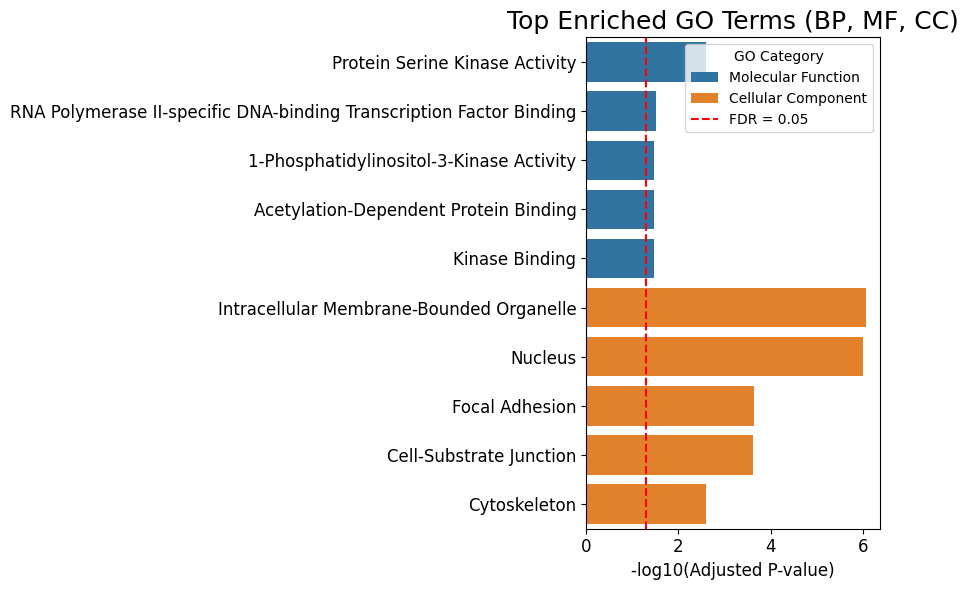

In [ ]:
go_bp = gp.enrichr(list(specific_4to2_metastatic_proteins), gene_sets='GO_Biological_Process_2025', organism='Human', outdir=None)
go_mf = gp.enrichr(list(specific_4to2_metastatic_proteins), gene_sets='GO_Molecular_Function_2025', organism='Human', outdir=None)
go_cc = gp.enrichr(list(specific_4to2_metastatic_proteins), gene_sets='GO_Cellular_Component_2025', organism='Human', outdir=None)

df_bp = prep_go_df(go_bp, 'Biological Process', 5)
df_mf = prep_go_df(go_mf, 'Molecular Function', 5)
df_cc = prep_go_df(go_cc, 'Cellular Component', 5)

# 4. Combine into one DataFrame
combined_df = pd.concat([df_bp, df_mf, df_cc], ignore_index=True)

# 5. Plot
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=combined_df,
    x='-log10(adj p-value)',
    y='Term',
    hue='GO Category',
)
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1.5, label='FDR = 0.05')

ax.tick_params(axis='x', labelsize=12) # Adjust labelsize as needed
ax.tick_params(axis='y', labelsize=12) # Adjust labelsize as needed

plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
plt.ylabel('')
plt.title('Top Enriched GO Terms (BP, MF, CC)', fontsize=18)
plt.legend(title='GO Category', loc='upper right')
plt.tight_layout()
plt.show()

**Enriched pathways in mostly metastatic tumor samples (5to2)**

Number of proteins found mostly (>=5) in lymph node metastatic, and less so (<=2) in non-metastatic samples:  95


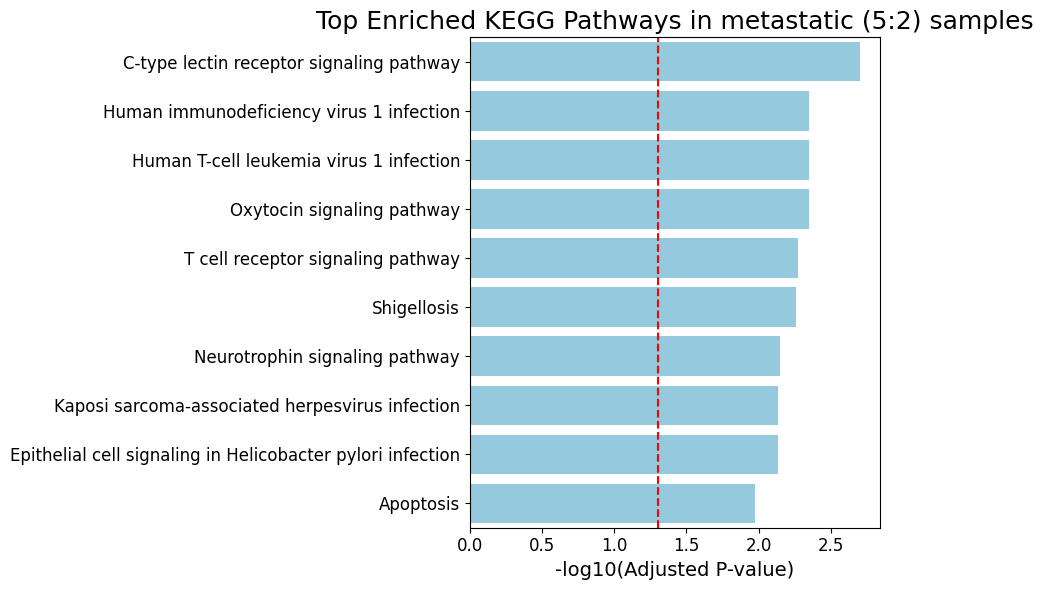

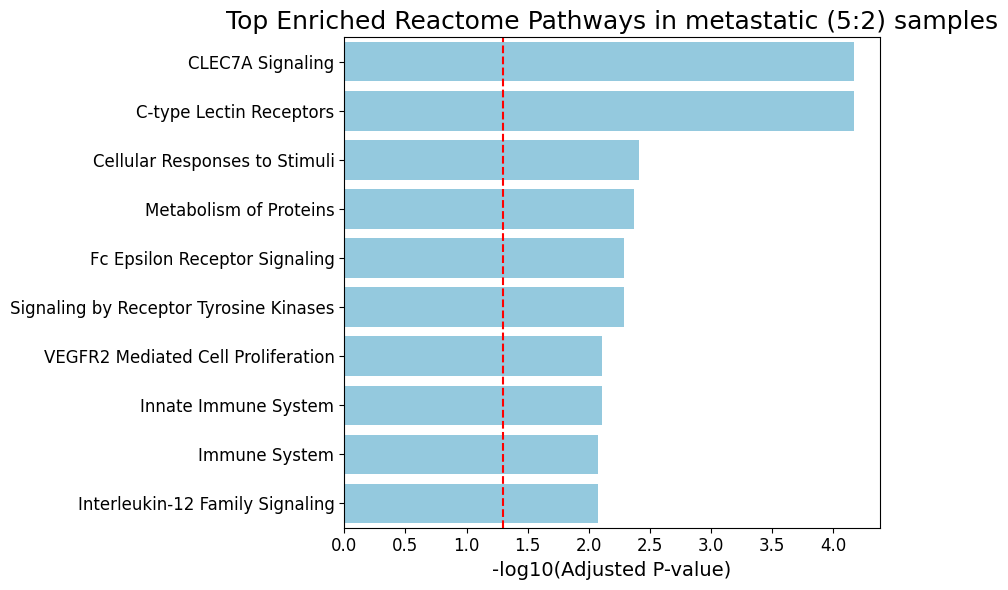

In [ ]:
specific_5to2_metastatic_proteins = find_group_specific_proteins(protein_set_A, protein_set_B, 5, 2)
print("Number of proteins found mostly (>=5) in lymph node metastatic, and less so (<=2) in non-metastatic samples: ",
      len(specific_5to2_metastatic_proteins))

plot_enrichment_barplot(gene_list=list(specific_5to2_metastatic_proteins),
                        gene_set='KEGG_2021_Human',
                        title='Top Enriched KEGG Pathways in metastatic (5:2) samples')

plot_enrichment_barplot(gene_list=list(specific_5to2_metastatic_proteins),
                        gene_set='Reactome_Pathways_2024',
                        title='Top Enriched Reactome Pathways in metastatic (5:2) samples')

#plot_enrichment_barplot(gene_list=list(specific_5to2_metastatic_proteins),
#                        gene_set='MSigDB_Hallmark_2020',
#                        title='Top Enriched MSigDB Pathways in metastatic (5:2) samples')


In [ ]:
print(df[['Term', 'Adjusted P-value', 'Overlap', 'Genes']])

#print lists of all of the genes for each pathway:
for index, row in df.iterrows():
  print(row['Term'], row['Genes'])

                                                Term  Adjusted P-value  \
0           C-type lectin receptor signaling pathway          0.001971   
1           Human immunodeficiency virus 1 infection          0.004508   
2            Human T-cell leukemia virus 1 infection          0.004508   
3                         Oxytocin signaling pathway          0.004508   
4                  T cell receptor signaling pathway          0.005326   
5                                        Shigellosis          0.005542   
6                     Neurotrophin signaling pathway          0.007144   
7    Kaposi sarcoma-associated herpesvirus infection          0.007389   
8  Epithelial cell signaling in Helicobacter pylo...          0.007389   
9                                          Apoptosis          0.010542   

  Overlap                                    Genes  
0   6/104      NFKBIA;JUN;PRKCD;NFATC2;ITPR2;CALM2  
1   7/212  NFKBIA;JUN;CUL1;NFATC2;ITPR2;CALR;CALM2  
2   7/219   NFKBIA;FDPS;JU

In [ ]:
## Proteins detected in at least 5 lymph node metastatic and at most 1 non-metastatic sample:
print(specific_5to1_metastatic_proteins)

mostly_met_df = pd.DataFrame(specific_5to2_metastatic_proteins, columns=['Protein'])
mostly_met_df.to_excel('mostly_met_5_2df.xlsx')

mostly_met_df = pd.DataFrame(specific_5to1_metastatic_proteins, columns=['Protein'])
mostly_met_df.to_excel('mostly_met_5_1df.xlsx')


{'ZMYM4', 'CALR', 'NFKBIA', 'SNX30', 'ERCC5', 'RPLP1', 'FBXO38', 'SNX2', 'MICU2', 'UBR7', 'IPP', 'DPM3', 'CANX', 'FAM49A', 'PSME2', 'SIK2', 'TMBIM4', 'ACTR10', 'SUPT7L', 'BTAF1', 'SEPT6', 'HUWE1', 'DRG1', 'NAA50', 'PTGS1', 'TM6SF1', 'CPA3', 'EP300', 'CALM2', 'ATP6V1C1', 'RPL8', 'ABR', 'ITPR2', 'ATL3', 'MSN', 'YPEL5', 'DMXL1', 'CAND1', 'SELENON', 'IFIT1', 'CSNK1A1', 'UBE2N', 'TIPRL', 'ARHGEF40', 'PDLIM1', 'RANBP9', 'JUN', 'H1F0', 'FDPS', 'MRFAP1', 'DDX17', 'FNDC3A', 'ANP32E', 'MCM7', 'GPAT4', 'ATP2A2', 'PRKCD', 'NEDD9', 'MAN2C1', 'NFATC2', 'RACK1', 'CUL1', 'GUCY1A1', 'SCD', 'DHX16', 'TJP1', 'EIF4A2', 'ARL6IP1', 'PTPN6', 'SEC24C', 'PDGFRB', 'JCHAIN', 'C3orf38', 'EIF3A', 'RBM39', 'POLR2C', 'IGFBP5', 'COPS6', 'CAMK1D', 'VPS13B', 'PDPK1', 'LARS', 'USF1', 'APEX2', 'SIN3A', 'CAPN2', 'PCBD1', 'CRNKL1', 'MIF', 'RPL19', 'BLVRA', 'FAM96B', 'LAMA4', 'TMED9', 'NES'}


In [ ]:
## Proteins detected in at least 6 lymph node metastatic and at most 1 non-met sample:
print(specific_6to1_metastatic_proteins)

{'PCBD1'}


In [ ]:
def summarize_proteins_across_samples(
    dataframes_dict,
    sample_labels,
    proteins_of_interest,
    q_value_threshold=None,
    signal_threshold=None,
    mode='count'  # 'count' or 'intensity'
):
    """
    Summarize peptides per source protein across samples by count or total intensity.
    Normalizes intensity values by the average signal intensity per sample

    Parameters:
    - dataframes_dict: dict of {sample_label: DataFrame}
    - sample_labels: list of sample names to use (must be keys in dataframes_dict)
    - proteins_of_interest: list of protein names/IDs to track
    - q_value_threshold: float, optional — filters peptides by q-value
    - signal_threshold: float, optional — filters peptides by signal intensity
    - mode: 'count' or 'intensity'

    Returns:
    - result_df: DataFrame with proteins as rows, samples as columns
    - missing_report: dict mapping protein -> list of samples where it was not detected
    """
    assert all(label in dataframes_dict for label in sample_labels), "Missing sample(s) in dataframes_dict"
    assert mode in {'count', 'intensity'}, "Mode must be 'count' or 'intensity'"

    result_df = pd.DataFrame(index=proteins_of_interest, columns=sample_labels)
    result_df[:] = 0  # Initialize with zeros

    missing_report = {protein: [] for protein in proteins_of_interest}

    for label in sample_labels:
        df = dataframes_dict[label].copy()

        # Apply filters
        if q_value_threshold is not None:
            df = df[df['q-value'] <= q_value_threshold]

        if signal_threshold is not None:
            df = df[df['Total ion current'] >= signal_threshold]

        # Summarize
        if mode == 'count':
            summary = df['Source Protein'].value_counts()
        elif mode == 'intensity':
            #normalize to max TIC
            ##norm_parameter = df['Total ion current'].max()
            #normalize to averaget TIC/peptide
            norm_parameter = df['Total ion current'].mean()
            df['Total ion current'] = df['Total ion current'] / norm_parameter
            #df['Total ion current'] = np.log2(df['Total ion current'] + 1)
            summary = df.groupby('Source Protein')['Total ion current'].sum()

        # Fill results and track missing proteins
        for protein in proteins_of_interest:
            if protein in summary:
                result_df.at[protein, label] = summary[protein]
            else:
                missing_report[protein].append(label)

    return result_df, missing_report



In [ ]:
result5to2_df_count, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels,
    list(specific_5to2_metastatic_proteins),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='count'
)

display(result5to2_df_count)
print(missing_report)

print()
print()

result5to2_df_intensity, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels,
    list(specific_5to2_metastatic_proteins),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='intensity'
)

display(result5to2_df_intensity)
print(missing_report)

print()
print()

result5to1_df_count, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels,
    list(specific_5to1_metastatic_proteins),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='count'
)

display(result5to1_df_count)
print(missing_report)

print()
print()

result5to1_df_intensity, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels,
    list(specific_5to1_metastatic_proteins),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='intensity'
)

display(result5to1_df_intensity)
print(missing_report)

,Sample_333,Sample_2339,Sample_977,Sample_825,Sample_2060,Sample_1097,Sample_1949
IPP,1,0,1,1,1,1,0
SUPT7L,1,1,2,1,1,2,1
LAMA4,1,1,1,2,1,0,0
ZMYM4,1,0,1,1,1,2,0
ARL6IP1,1,0,0,1,1,1,2
...,...,...,...,...,...,...,...
TJP1,2,1,3,0,1,1,0
BTAF1,2,1,1,1,3,1,0
FBXO38,1,0,2,1,2,1,0
RPL19,3,1,1,0,0,1,1


{'IPP': ['Sample_2339', 'Sample_1949'], 'SUPT7L': [], 'LAMA4': ['Sample_1097', 'Sample_1949'], 'ZMYM4': ['Sample_2339', 'Sample_1949'], 'ARL6IP1': ['Sample_2339', 'Sample_977'], 'MICU2': ['Sample_2339', 'Sample_1097'], 'CUL1': ['Sample_977', 'Sample_2060'], 'JCHAIN': ['Sample_825', 'Sample_1949'], 'SEC24C': ['Sample_333', 'Sample_2339'], 'PCBD1': ['Sample_1949'], 'SNX2': ['Sample_2339', 'Sample_2060'], 'TM6SF1': ['Sample_825', 'Sample_1949'], 'CAMK1D': ['Sample_333', 'Sample_825'], 'GPAT4': ['Sample_2339', 'Sample_977'], 'CALR': ['Sample_2339', 'Sample_977'], 'IGFBP5': ['Sample_825', 'Sample_1949'], 'PDGFRB': ['Sample_2060', 'Sample_1949'], 'ABR': ['Sample_2339', 'Sample_2060'], 'RBM39': ['Sample_825', 'Sample_2060'], 'YPEL5': ['Sample_1949'], 'FNDC3A': ['Sample_2339', 'Sample_1949'], 'ANP32E': ['Sample_2339'], 'DPM3': ['Sample_333', 'Sample_2339'], 'GUCY1A1': ['Sample_1097', 'Sample_1949'], 'SEPT6': ['Sample_2339', 'Sample_1097'], 'PDPK1': ['Sample_2339', 'Sample_1949'], 'JUN': ['Samp

,Sample_333,Sample_2339,Sample_977,Sample_825,Sample_2060,Sample_1097,Sample_1949
IPP,0.909633,0,0.45103,0.589839,0.374922,0.865014,0
SUPT7L,0.81322,0.469805,1.127575,0.721728,0.487021,2.341276,0.550994
LAMA4,0.777589,0.334932,2.282368,1.513064,0.350151,0,0
ZMYM4,0.886578,0,0.913725,1.938041,0.29809,1.705755,0
ARL6IP1,1.079403,0,0,1.02947,0.309846,0.311582,1.892269
...,...,...,...,...,...,...,...
TJP1,1.530028,0.649634,1.644704,0,0.220839,0.975348,0
BTAF1,0.747199,0.528249,0.995377,0.534885,2.870905,0.485467,0
FBXO38,0.29343,0,0.602669,0.251323,0.740188,0.409999,0
RPL19,1.65264,1.121686,0.855402,0,0,0.042589,5.352509


{'IPP': ['Sample_2339', 'Sample_1949'], 'SUPT7L': [], 'LAMA4': ['Sample_1097', 'Sample_1949'], 'ZMYM4': ['Sample_2339', 'Sample_1949'], 'ARL6IP1': ['Sample_2339', 'Sample_977'], 'MICU2': ['Sample_2339', 'Sample_1097'], 'CUL1': ['Sample_977', 'Sample_2060'], 'JCHAIN': ['Sample_825', 'Sample_1949'], 'SEC24C': ['Sample_333', 'Sample_2339'], 'PCBD1': ['Sample_1949'], 'SNX2': ['Sample_2339', 'Sample_2060'], 'TM6SF1': ['Sample_825', 'Sample_1949'], 'CAMK1D': ['Sample_333', 'Sample_825'], 'GPAT4': ['Sample_2339', 'Sample_977'], 'CALR': ['Sample_2339', 'Sample_977'], 'IGFBP5': ['Sample_825', 'Sample_1949'], 'PDGFRB': ['Sample_2060', 'Sample_1949'], 'ABR': ['Sample_2339', 'Sample_2060'], 'RBM39': ['Sample_825', 'Sample_2060'], 'YPEL5': ['Sample_1949'], 'FNDC3A': ['Sample_2339', 'Sample_1949'], 'ANP32E': ['Sample_2339'], 'DPM3': ['Sample_333', 'Sample_2339'], 'GUCY1A1': ['Sample_1097', 'Sample_1949'], 'SEPT6': ['Sample_2339', 'Sample_1097'], 'PDPK1': ['Sample_2339', 'Sample_1949'], 'JUN': ['Samp

,Sample_333,Sample_2339,Sample_977,Sample_825,Sample_2060,Sample_1097,Sample_1949
IGFBP5,3,1,2,0,1,1,0
SEPT6,1,0,1,2,3,0,1
ARL6IP1,1,0,0,1,1,1,2
PDLIM1,1,0,0,1,2,1,1
PCBD1,1,1,1,1,2,1,0
H1F0,2,0,1,0,1,1,1
APEX2,1,0,0,1,1,2,1
JUN,5,0,4,2,0,1,1
ACTR10,1,0,3,0,1,1,1
RANBP9,1,0,2,1,0,1,1


{'IGFBP5': ['Sample_825', 'Sample_1949'], 'SEPT6': ['Sample_2339', 'Sample_1097'], 'ARL6IP1': ['Sample_2339', 'Sample_977'], 'PDLIM1': ['Sample_2339', 'Sample_977'], 'PCBD1': ['Sample_1949'], 'H1F0': ['Sample_2339', 'Sample_825'], 'APEX2': ['Sample_2339', 'Sample_977'], 'JUN': ['Sample_2339', 'Sample_2060'], 'ACTR10': ['Sample_2339', 'Sample_825'], 'RANBP9': ['Sample_2339', 'Sample_2060'], 'MICU2': ['Sample_2339', 'Sample_1097'], 'CRNKL1': ['Sample_977', 'Sample_1949'], 'EIF4A2': ['Sample_2339', 'Sample_1949'], 'TIPRL': ['Sample_2339', 'Sample_1949']}




,Sample_333,Sample_2339,Sample_977,Sample_825,Sample_2060,Sample_1097,Sample_1949
IGFBP5,29.91414,5.732065,28.171881,0,0.219579,0.439568,0
SEPT6,3.437323,0,1.119799,1.35553,1.975374,0,0.610816
ARL6IP1,1.079403,0,0,1.02947,0.309846,0.311582,1.892269
PDLIM1,0.404514,0,0,1.381175,2.011061,0.609041,4.156066
PCBD1,0.224264,0.577702,4.5103,0.42864,2.863348,0.43339,0
H1F0,4.726319,0,0.738756,0,0.319922,0.4634,0.824916
APEX2,0.618299,0,0,0.516567,0.366945,1.540255,0.256291
JUN,7.72664,0,7.623963,2.220138,0,0.812054,0.651747
ACTR10,0.908585,0,2.402124,0,3.039683,0.569321,0.673786
RANBP9,0.332205,0,0.804855,0.70341,0,0.569321,0.330596


{'IGFBP5': ['Sample_825', 'Sample_1949'], 'SEPT6': ['Sample_2339', 'Sample_1097'], 'ARL6IP1': ['Sample_2339', 'Sample_977'], 'PDLIM1': ['Sample_2339', 'Sample_977'], 'PCBD1': ['Sample_1949'], 'H1F0': ['Sample_2339', 'Sample_825'], 'APEX2': ['Sample_2339', 'Sample_977'], 'JUN': ['Sample_2339', 'Sample_2060'], 'ACTR10': ['Sample_2339', 'Sample_825'], 'RANBP9': ['Sample_2339', 'Sample_2060'], 'MICU2': ['Sample_2339', 'Sample_1097'], 'CRNKL1': ['Sample_977', 'Sample_1949'], 'EIF4A2': ['Sample_2339', 'Sample_1949'], 'TIPRL': ['Sample_2339', 'Sample_1949']}


In [ ]:
result_allshared_intensity, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels,
    list(proteins_shared_across_all),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='intensity'
)

display(result_allshared_intensity)
print(missing_report)

,Sample_333,Sample_2339,Sample_977,Sample_825,Sample_2060,Sample_1097,Sample_1949
MYO1B,0.199113,0.254009,1.318096,2.502235,1.637398,1.963053,1.388504
HNRNPA0,0.420234,2.346775,0.820408,1.187004,6.371998,2.475882,1.410544
FNDC3B,4.382587,0.568711,19.981409,1.099078,2.565257,6.191913,0.440795
STAT2,0.162434,0.604677,1.98531,1.941705,11.449613,3.193932,2.805344
XPO1,3.500201,1.515063,6.103681,4.227055,6.887989,0.820881,1.171255
...,...,...,...,...,...,...,...
VCAN,5.236677,3.729214,6.235879,1.04156,5.802268,4.574866,1.247135
MYO9B,1.058444,0.530497,0.614334,1.327686,1.624383,1.429921,0.525805
CYBB,0.555421,1.247567,0.304834,70.388631,0.482823,0.295694,1.127175
ABCA1,3.142845,1.308259,3.809649,10.36101,4.006168,1.82315,4.455177


{'MYO1B': [], 'HNRNPA0': [], 'FNDC3B': [], 'STAT2': [], 'XPO1': [], 'KIFAP3': [], 'DOCK10': [], 'MAP1B': [], 'DDB1': [], 'RNF213': [], 'SUPT6H': [], 'MYH9': [], 'COPB2': [], 'PRKDC': [], 'CTNNB1': [], 'SPTBN1': [], 'RPN2': [], 'FN1': [], 'BIRC6': [], 'SON': [], 'SPTAN1': [], 'FLNA': [], 'SOAT1': [], 'SF3B1': [], 'ADD1': [], 'TRRAP': [], 'TKT': [], 'HNRNPU': [], 'PPP2R1A': [], 'UPF1': [], 'CYFIP1': [], 'HNRNPL': [], 'EPRS': [], 'PLEC': [], 'PSMD2': [], 'VPS13C': [], 'KANK2': [], 'MDN1': [], 'HSP90AB1': [], 'SAMHD1': [], 'LMNA': [], 'INTS1': [], 'ATP6AP1': [], 'ITGAV': [], 'UBR2': [], 'CTNNA1': [], 'AHNAK': [], 'EHD2': [], 'TLN1': [], 'ETS1': [], 'PLXNB2': [], 'ACTR2': [], 'QKI': [], 'ATP6AP2': [], 'COL6A3': [], 'EIF4G1': [], 'IQGAP1': [], 'TNS3': [], 'NFE2L2': [], 'EEF2': [], 'HNRNPA2B1': [], 'TSC2': [], 'ATM': [], 'SFPQ': [], 'PRPF8': [], 'STAT1': [], 'CLTC': [], 'CSDE1': [], 'HNRNPK': [], 'RPN1': [], 'DYNC1H1': [], 'COL6A2': [], 'MAGED2': [], 'ANXA2': [], 'SEC31A': [], 'STAT3': [], 'R

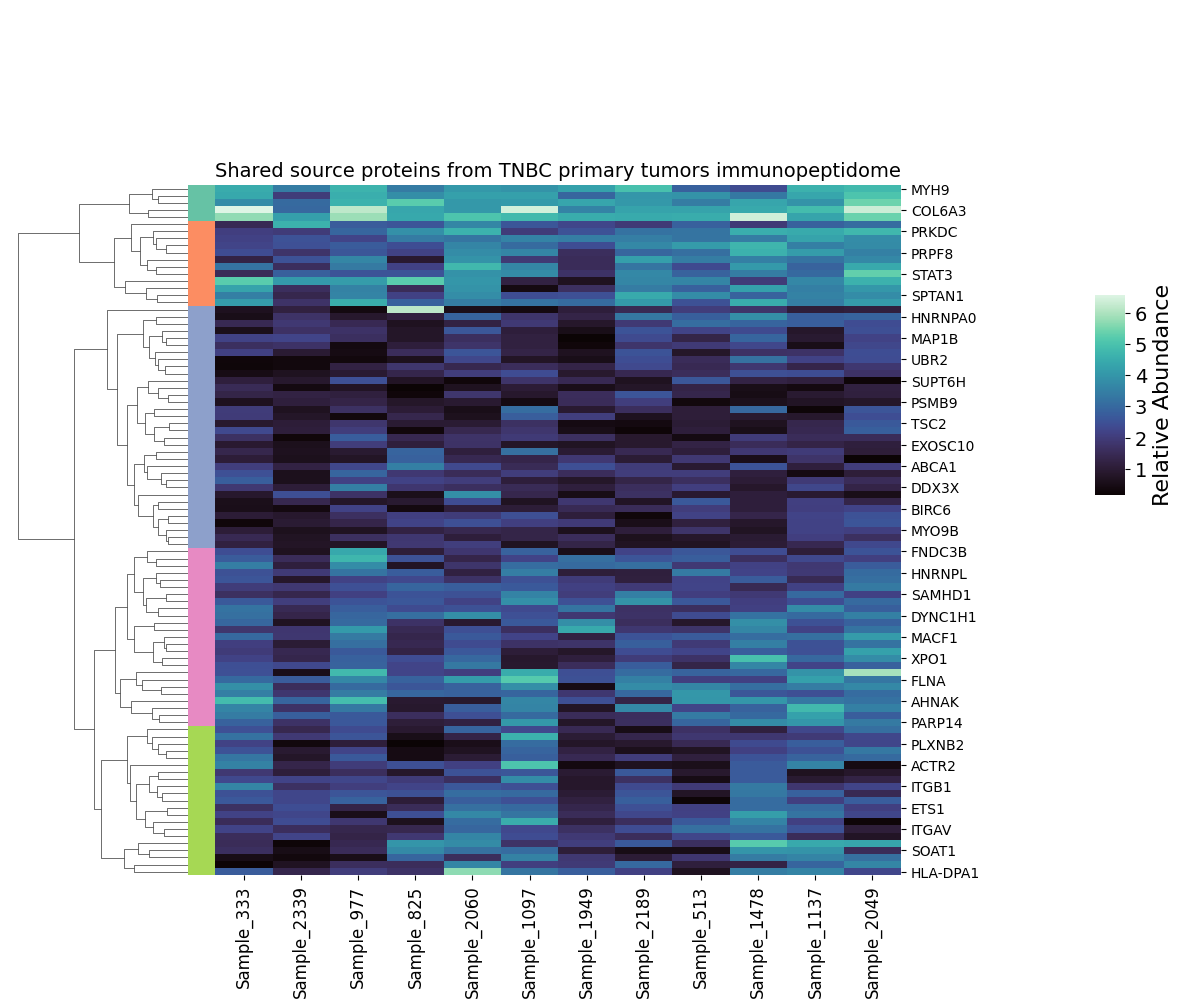

In [ ]:
## Heatmap of proteins shared across_all_samples

result_allshared_intensity, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels+NLN_spread_labels,
    list(proteins_shared_across_all),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='intensity'
)
result_allshared_intensity = result_allshared_intensity.apply(pd.to_numeric)
result_allshared_intensity = result_allshared_intensity.apply(lambda x: np.log2(x + 1))

dist_matrix_eu = pdist(result_allshared_intensity, metric='euclidean')

# Perform linkage using the distance matrix # test average
Z = sch.linkage(dist_matrix_eu, method='complete', metric='euclidean')

# Generate flat clusters using a threshold (e.g., 10 clusters)
max_clusters = 5
flat_clusters = fcluster(Z, t=max_clusters, criterion='maxclust')

# Add the cluster labels to the dataframe
#flat_clusters = fcluster(Z_complete_euclidean, t=max_clusters, criterion='maxclust')

# Map flat cluster labels to colors
palette = sns.color_palette("Set2", max_clusters)
row_colors = [palette[i - 1] for i in flat_clusters]

# Plot the heatmap with clusters as row colors
g = sns.clustermap(
    result_allshared_intensity,
    method='complete',
    metric='euclidean',
    cmap='mako',
    #figsize=(10, 16),
    row_cluster=True,
    col_cluster=False, ### Proteins shared across all are mostly cytoskeletal, housekeeping
    row_colors=row_colors,
    xticklabels=result_allshared_intensity.columns,
    cbar_pos=(1.1, .5, .03, .2),
)

g.ax_heatmap.set_title('Shared source proteins from TNBC primary tumors immunopeptidome', fontsize=14)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=12)

# Adjust font size of colorbar tick labels
for label in g.cax.get_yticklabels():
      label.set_fontsize(14)

# Adjust colorbar label font size
cbar = g.ax_cbar
cbar.set_ylabel('Relative Abundance', fontsize=16)

plt.show()


In [ ]:
result_allshared_intensity.loc['MAGED2']

,MAGED2
Sample_333,2.283650
Sample_2339,2.192073
Sample_977,2.236832
Sample_825,1.974851
Sample_2060,1.620135
Sample_1097,3.773108
Sample_1949,0.835104
Sample_2189,1.662365
Sample_513,0.451245
Sample_1478,2.703759


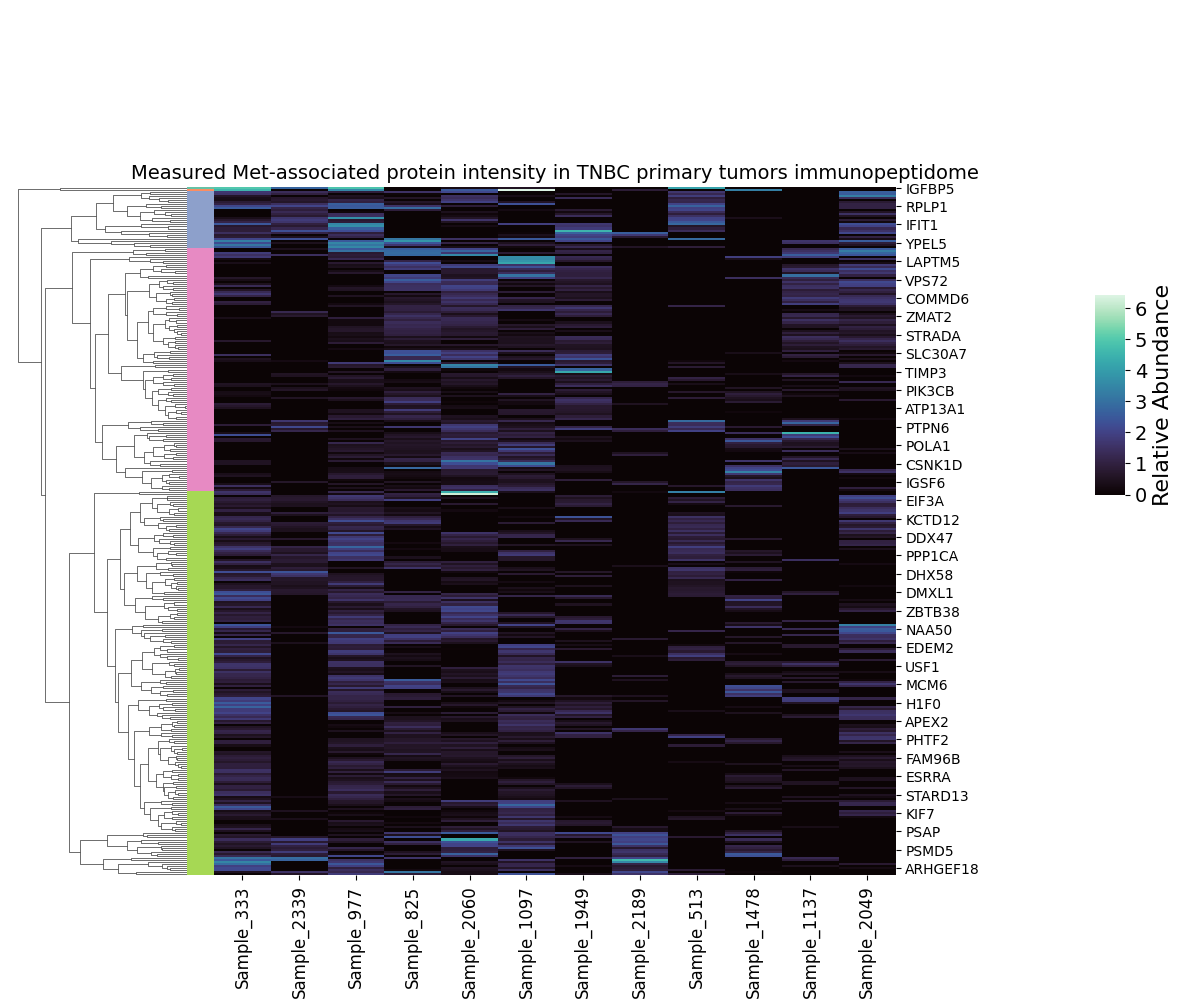

In [ ]:
## Heatmap of proteins mostly in metastatic samples

result_4to1_specific, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels+NLN_spread_labels,
    list(specific_4to2_metastatic_proteins),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='intensity'
)
result_4to1_specific = result_4to1_specific.apply(pd.to_numeric)
result_4to1_specific = result_4to1_specific.apply(lambda x: np.log2(x + 1))

dist_matrix_eu = pdist(result_4to1_specific, metric='cityblock')

# Perform linkage using the distance matrix # test average
Z = sch.linkage(dist_matrix_eu, method='complete',metric = 'cityblock')

# Generate flat clusters using a threshold (e.g., 10 clusters)
max_clusters = 5
flat_clusters = fcluster(Z, t=max_clusters, criterion='maxclust')

# Add the cluster labels to the dataframe
#flat_clusters = fcluster(Z_complete_euclidean, t=max_clusters, criterion='maxclust')

# Map flat cluster labels to colors
palette = sns.color_palette("Set2", max_clusters)
row_colors = [palette[i - 1] for i in flat_clusters]

# Plot the heatmap with clusters as row colors
g = sns.clustermap(
    result_4to1_specific,
    method='complete',
    metric='cityblock',
    cmap='mako',
    #figsize=(10, 16),
    row_cluster=True,
    col_cluster=False,
    row_colors=row_colors,
    xticklabels=result_4to1_specific.columns,
    cbar_pos=(1.1, .5, .03, .2),
)

g.ax_heatmap.set_title('Measured Met-associated protein intensity in TNBC primary tumors immunopeptidome', fontsize=14)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=12)

# Adjust font size of colorbar tick labels
for label in g.cax.get_yticklabels():
      label.set_fontsize(14)

# Adjust colorbar label font size
cbar = g.ax_cbar
cbar.set_ylabel('Relative Abundance', fontsize=16)

plt.show()


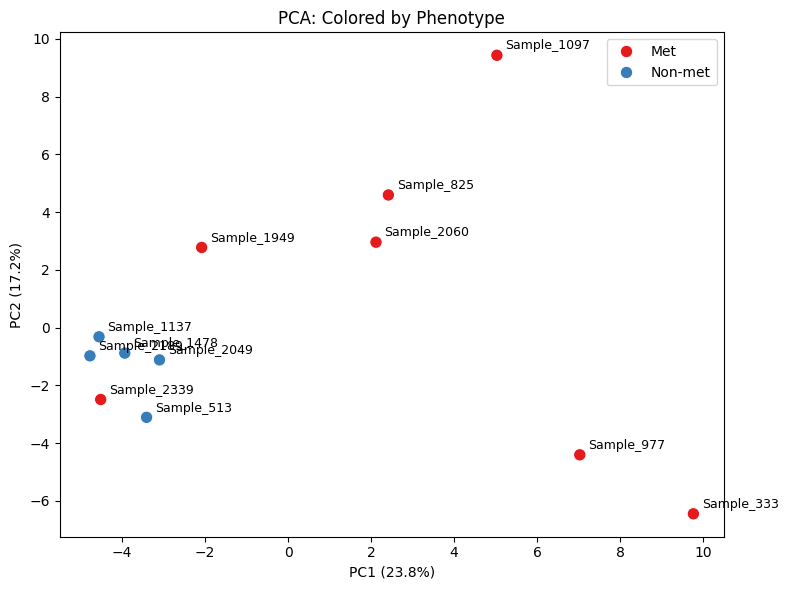

In [ ]:

# Transpose if your data is genes as rows and samples as columns
result_4to1_intensity, missing_report = summarize_proteins_across_samples(
    all_samples,
    N_spread_labels+NLN_spread_labels,
    list(specific_4to1_metastatic_proteins),
#    q_value_threshold=0.01,             # Optional
#    signal_threshold=1e5                # Optional
    mode='intensity'
)
data = result_4to1_intensity.copy()
data = data.T

# Standardize (mean=0, variance=1) across each feature
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(data)

# Perform PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

phenotype = pd.Series(
    ['Met', 'Met', 'Met', 'Met', 'Met', 'Met', 'Met',
     'Non-met', 'Non-met', 'Non-met', 'Non-met', 'Non-met'],
    index=['Sample_333','Sample_2339','Sample_977','Sample_825','Sample_2060','Sample_1097','Sample_1949',
           'Sample_2189','Sample_513','Sample_1478','Sample_1137','Sample_2049']
)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=data.index)
pca_df['Phenotype'] = phenotype


# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Phenotype',
    data=pca_df,
    palette='Set1',
    s=80
)

for i in pca_df.index:
    plt.text(
        x=pca_df.loc[i, 'PC1'] + 0.2,  # small offset so label doesn't overlap the dot
        y=pca_df.loc[i, 'PC2'] + 0.2,
        s=i,
        fontsize=9
    )

plt.title('PCA: Colored by Phenotype')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
all_proteins_detected = find_group_specific_proteins(protein_set_A, protein_set_B,0,0)
print(len(all_proteins_detected))

1670


# **GSEA ON PROTEINS FOUND MOSTLY IN NON-METASTATIC**

In [ ]:
specific_4to2_nonmet_proteins = find_group_specific_proteins(protein_set_B, protein_set_A, 4, 2)
print("Number of proteins found mostly (>=4) in non-metastatic, and less so (<=2) in metastatic samples: ",
      len(specific_4to2_nonmet_proteins))

specific_4to1_nonmet_proteins = find_group_specific_proteins(protein_set_B, protein_set_A, 4, 1)
print("Number of proteins found mostly (>=4) in non-metastatic, and less so (<=1) in metastatic samples: ",
      len(specific_4to1_nonmet_proteins))

specific_5to1_nonmet_proteins = find_group_specific_proteins(protein_set_B, protein_set_A, 5, 1)
print("Number of proteins found mostly (>=5) in non-metastatic, and less so (<=1) in metastatic samples: ",
      len(specific_5to1_nonmet_proteins))

specific_6to1_nonmet_proteins = find_group_specific_proteins(protein_set_B, protein_set_A, 6, 1)
print("Number of proteins found mostly (>=6) in non-metastatic, and less so (<=1) in metastatic samples: ",
      len(specific_6to1_nonmet_proteins))

print(len(find_group_specific_proteins(protein_set_B, protein_set_A,7,0)))

Number of proteins found mostly (>=4) in non-metastatic, and less so (<=2) in metastatic samples:  358
Number of proteins found mostly (>=4) in non-metastatic, and less so (<=1) in metastatic samples:  180
Number of proteins found mostly (>=5) in non-metastatic, and less so (<=1) in metastatic samples:  56
Number of proteins found mostly (>=6) in non-metastatic, and less so (<=1) in metastatic samples:  0
0


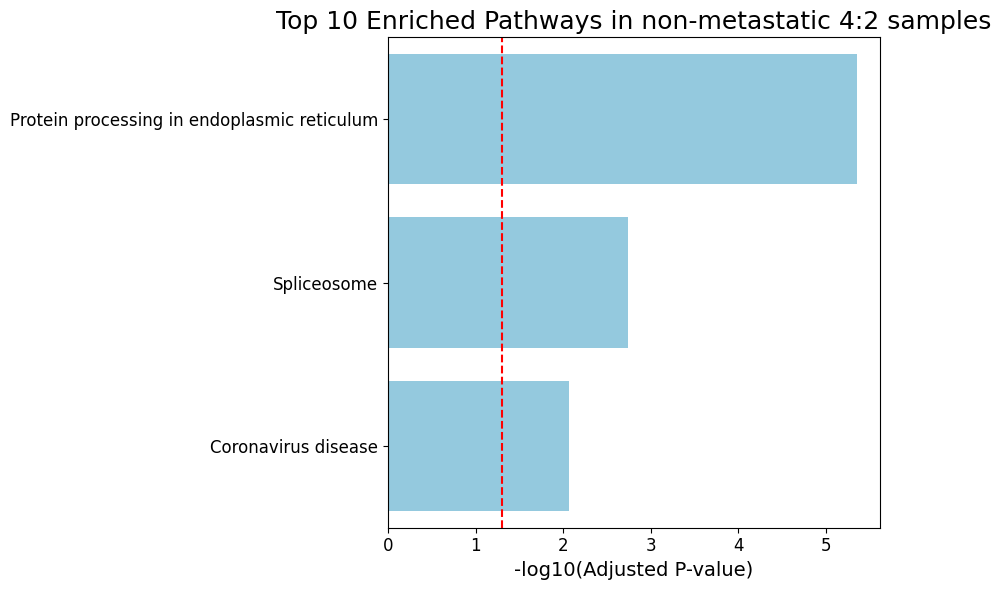

In [ ]:
enr = gp.enrichr(gene_list=list(unique_proteins_B),
                 gene_sets='KEGG_2021_Human',
                 organism='Human',
                 outdir='enrichr_results',
                 cutoff=0.05)  # Adjust FDR cutoff

# Make SNS barplot manually
df = enr.results.copy()
df = df[df['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value').head(10)
df['-log10(adj p-value)'] = -np.log10(df['Adjusted P-value'])
df['Term'] = df['Term'].str.replace(r' \(.*\)', '', regex=True)

# Plot barplot
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=df,
    x='-log10(adj p-value)',
    y='Term',
    color='skyblue'
)
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1.5, label='FDR = 0.05')

ax.tick_params(axis='x', labelsize=12) # Adjust labelsize as needed
ax.tick_params(axis='y', labelsize=12) # Adjust labelsize as needed

plt.xlabel('-log10(Adjusted P-value)', fontsize=14)
plt.ylabel('')
plt.title('Top 10 Enriched Pathways in non-metastatic 4:2 samples', fontsize=18)
plt.tight_layout()
plt.show()


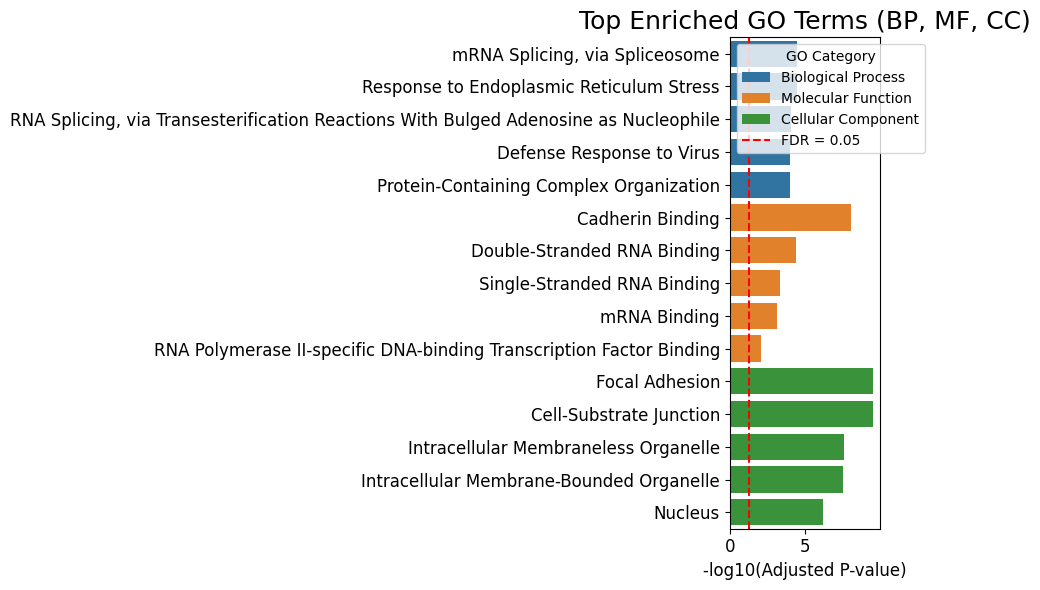

In [ ]:
go_bp = gp.enrichr(list(unique_proteins_B), gene_sets='GO_Biological_Process_2025', organism='Human', outdir=None)
go_mf = gp.enrichr(list(unique_proteins_B), gene_sets='GO_Molecular_Function_2025', organism='Human', outdir=None)
go_cc = gp.enrichr(list(unique_proteins_B), gene_sets='GO_Cellular_Component_2025', organism='Human', outdir=None)

df_bp = prep_go_df(go_bp, 'Biological Process', 5)
df_mf = prep_go_df(go_mf, 'Molecular Function', 5)
df_cc = prep_go_df(go_cc, 'Cellular Component', 5)

# 4. Combine into one DataFrame
combined_df = pd.concat([df_bp, df_mf, df_cc], ignore_index=True)

# 5. Plot
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=combined_df,
    x='-log10(adj p-value)',
    y='Term',
    hue='GO Category',
)
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1.5, label='FDR = 0.05')

ax.tick_params(axis='x', labelsize=12) # Adjust labelsize as needed
ax.tick_params(axis='y', labelsize=12) # Adjust labelsize as needed

plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
plt.ylabel('')
plt.title('Top Enriched GO Terms (BP, MF, CC)', fontsize=18)
plt.legend(title='GO Category', loc='best')
plt.tight_layout()
plt.show()

# ** TIC Analysis for every protein detected**

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


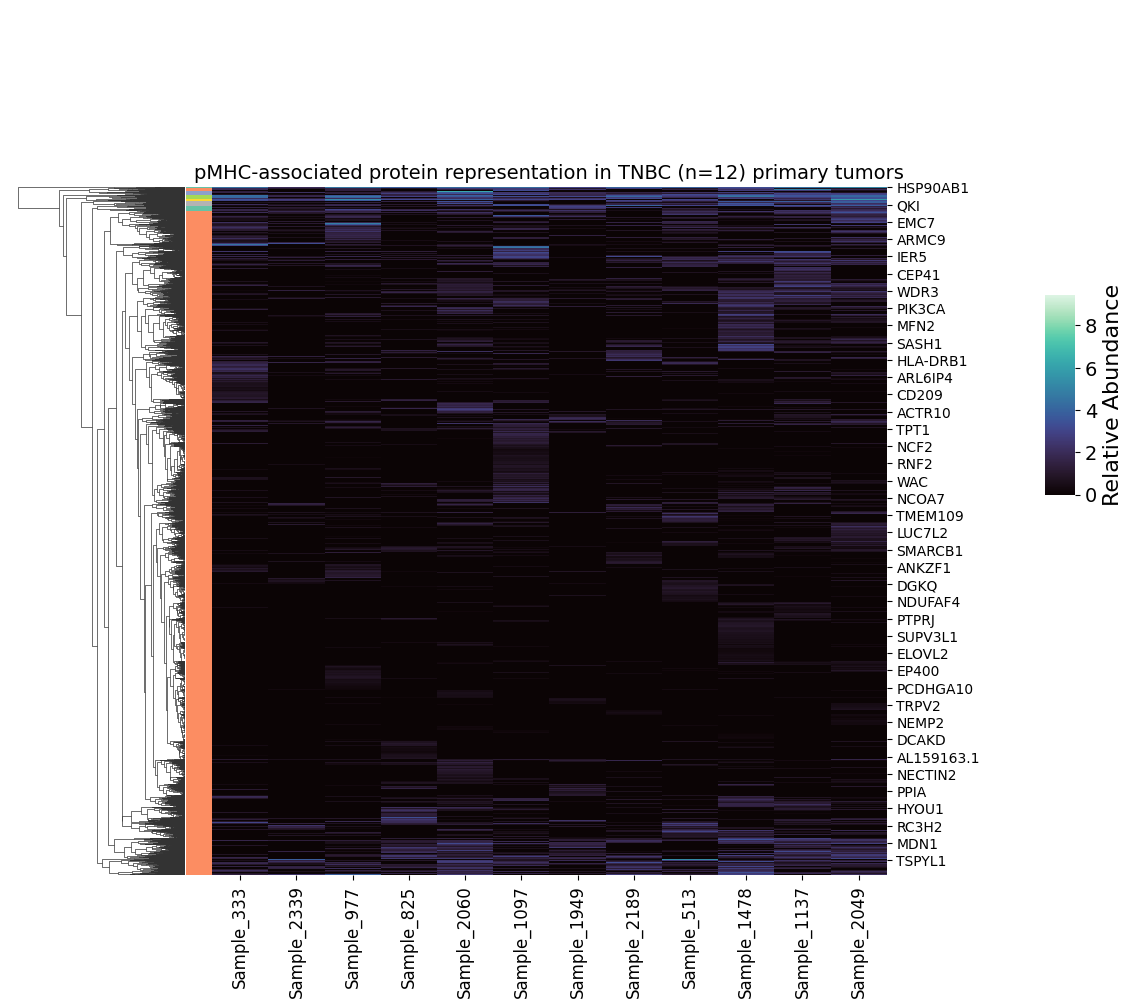

In [ ]:
all_proteins_Nodespread = set.union(*protein_set_A)
all_proteins_Nonodespread = set.union(*protein_set_B)

every_protein_detected = all_proteins_Nodespread.union(all_proteins_Nonodespread)

every_protein_detected_df, missing_report = summarize_proteins_across_samples(all_samples, N_spread_labels+NLN_spread_labels,
                                                                              list(every_protein_detected), mode='intensity')

every_protein_detected_df = every_protein_detected_df.apply(pd.to_numeric)
every_protein_detected_df = every_protein_detected_df.apply(lambda x: np.log2(x + 1))

dist_matrix_eu = pdist(every_protein_detected_df, metric='euclidean')

# Perform linkage using the distance matrix # test average
Z = sch.linkage(dist_matrix_eu, method='complete')

# Generate flat clusters using a threshold (e.g., 10 clusters)
max_clusters = 10
flat_clusters = fcluster(Z, t=max_clusters, criterion='maxclust')

# Add the cluster labels to the dataframe
#flat_clusters = fcluster(Z_complete_euclidean, t=max_clusters, criterion='maxclust')

# Map flat cluster labels to colors
palette = sns.color_palette("Set2", max_clusters)
row_colors = [palette[i - 1] for i in flat_clusters]

# Plot the heatmap with clusters as row colors
g = sns.clustermap(
    every_protein_detected_df,
    method='complete',
    metric='euclidean',
    cmap='mako',
    #figsize=(10, 16),
    row_cluster=True,
    col_cluster=False,
    row_colors=row_colors,
    xticklabels=every_protein_detected_df.columns,
    cbar_pos=(1.05, .5, .03, .2),
)

g.ax_heatmap.set_title('pMHC-associated protein representation in TNBC (n=12) primary tumors', fontsize=14)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=12)

# Adjust font size of colorbar tick labels
for label in g.cax.get_yticklabels():
      label.set_fontsize(14)

# Adjust colorbar label font size
cbar = g.ax_cbar
cbar.set_ylabel('Relative Abundance', fontsize=16)

plt.show()

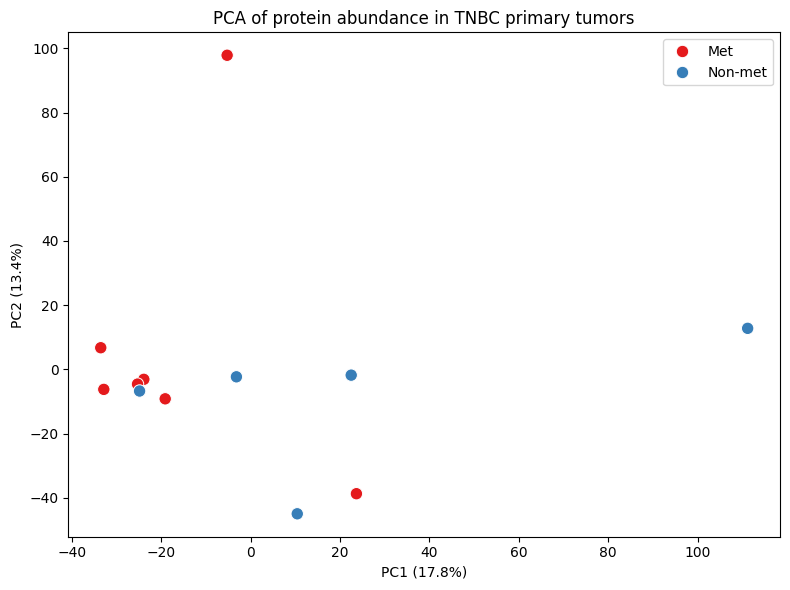

In [ ]:
data = every_protein_detected_df.copy()
data = data.T

# Standardize (mean=0, variance=1) across each feature
X_scaled = StandardScaler().fit_transform(data)

# Perform PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

phenotype = pd.Series(
    ['Met', 'Met', 'Met', 'Met', 'Met', 'Met', 'Met',
     'Non-met', 'Non-met', 'Non-met', 'Non-met', 'Non-met'],
    index=['Sample_333','Sample_2339','Sample_977','Sample_825','Sample_2060','Sample_1097','Sample_1949',
           'Sample_2189','Sample_513','Sample_1478','Sample_1137','Sample_2049']
)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=data.index)
pca_df['Phenotype'] = phenotype


# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Phenotype',
    data=pca_df,
    palette='Set1',
    s=80
)

## SHOW LABELS (OPTIONAL)
#for i in pca_df.index:
#    plt.text(
#        x=pca_df.loc[i, 'PC1'] + 0.2,  # small offset so label doesn't overlap the dot
#        y=pca_df.loc[i, 'PC2'] + 0.2,
#        s=i,
#       fontsize=9
#    )


plt.title('PCA of protein abundance in TNBC primary tumors')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.tight_layout()
plt.show()

# **Protein Abundance analysis with every protein detected**

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


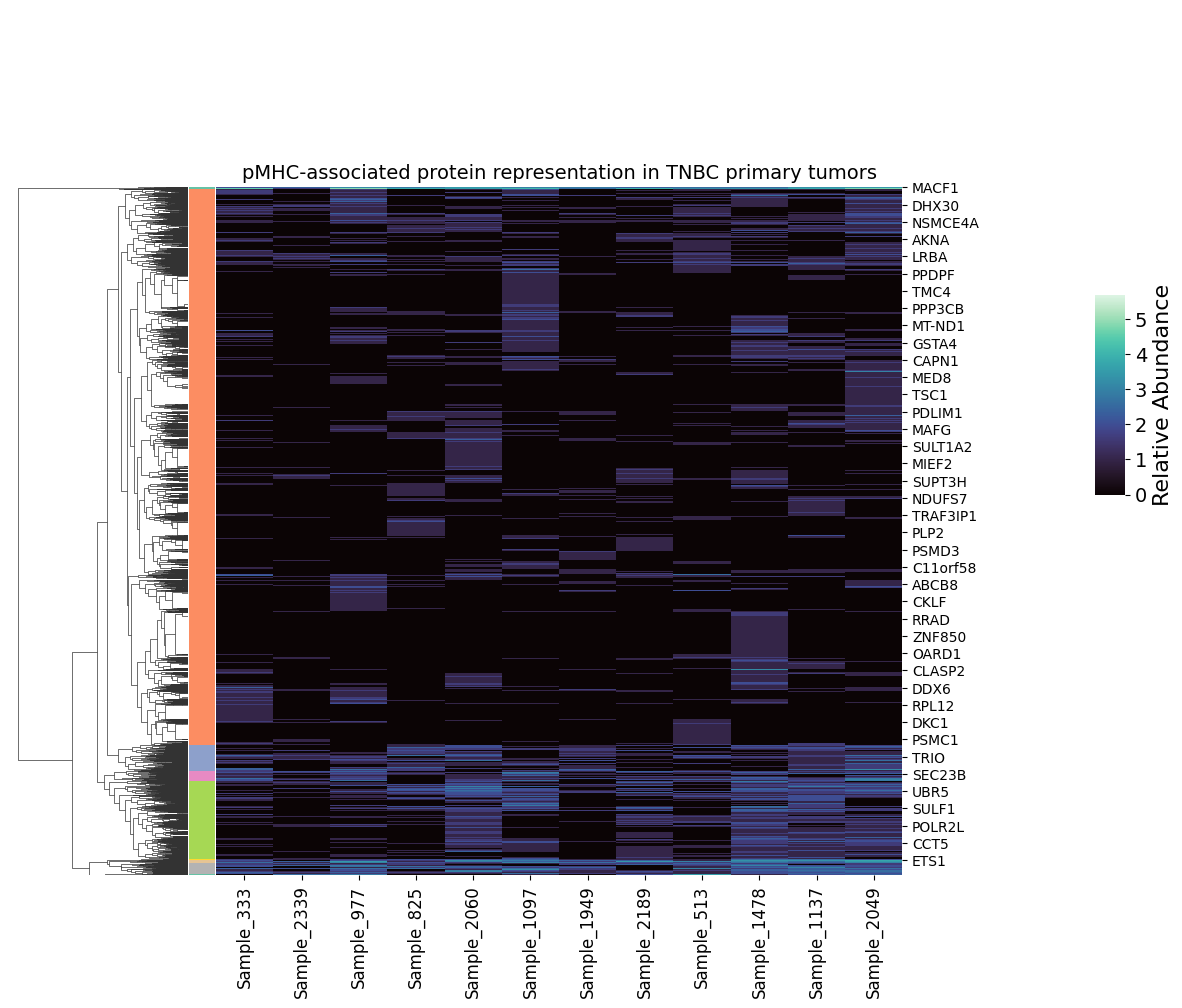

In [ ]:
every_protein_detected_df, missing_report = summarize_proteins_across_samples(all_samples, N_spread_labels+NLN_spread_labels, list(every_protein_detected), mode='count')

every_protein_detected_df = every_protein_detected_df.apply(pd.to_numeric)
every_protein_detected_df = every_protein_detected_df.apply(lambda x: np.log2(x + 1))

dist_matrix_eu = pdist(every_protein_detected_df, metric='euclidean')

# Perform linkage using the distance matrix # test average
Z = sch.linkage(dist_matrix_eu, method='complete')

# Generate flat clusters using a threshold (e.g., 10 clusters)
max_clusters = 10
flat_clusters = fcluster(Z, t=max_clusters, criterion='maxclust')

# Add the cluster labels to the dataframe
#flat_clusters = fcluster(Z_complete_euclidean, t=max_clusters, criterion='maxclust')

# Map flat cluster labels to colors
palette = sns.color_palette("Set2", max_clusters)
row_colors = [palette[i - 1] for i in flat_clusters]

# Plot the heatmap with clusters as row colors
g = sns.clustermap(
    every_protein_detected_df,
    method='complete',
    metric='euclidean',
    cmap='mako',
    #figsize=(10, 16),
    row_cluster=True,
    col_cluster=False,
    row_colors=row_colors,
    xticklabels=every_protein_detected_df.columns,
    cbar_pos=(1.1, .5, .03, .2),
)

g.ax_heatmap.set_title('pMHC-associated protein representation in TNBC primary tumors', fontsize=14)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=12)

# Adjust font size of colorbar tick labels
for label in g.cax.get_yticklabels():
      label.set_fontsize(14)

# Adjust colorbar label font size
cbar = g.ax_cbar
cbar.set_ylabel('Relative Abundance', fontsize=16)

plt.show()


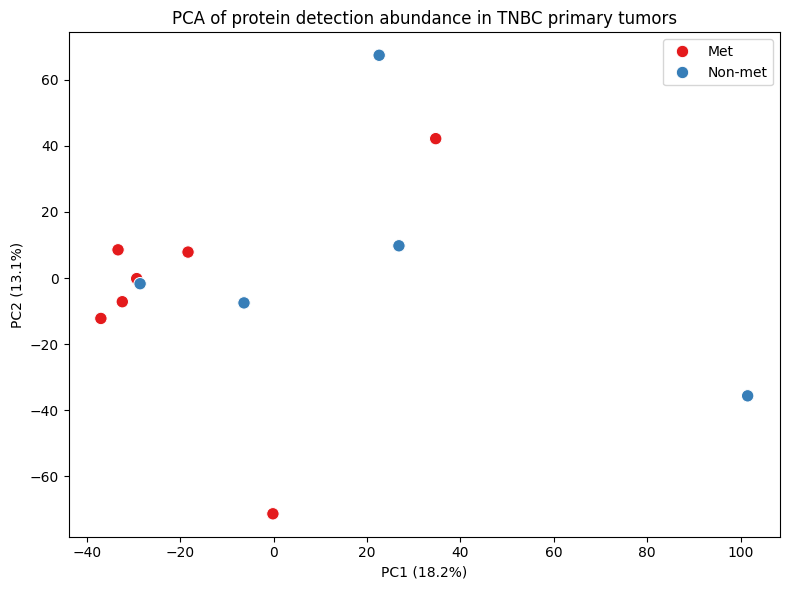

In [ ]:
data = every_protein_detected_df.copy()
data = data.T

# Standardize (mean=0, variance=1) across each feature
X_scaled = StandardScaler().fit_transform(data)

# Perform PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

phenotype = pd.Series(
    ['Met', 'Met', 'Met', 'Met', 'Met', 'Met', 'Met',
     'Non-met', 'Non-met', 'Non-met', 'Non-met', 'Non-met'],
    index=['Sample_333','Sample_2339','Sample_977','Sample_825','Sample_2060','Sample_1097','Sample_1949',
           'Sample_2189','Sample_513','Sample_1478','Sample_1137','Sample_2049']
)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=data.index)
pca_df['Phenotype'] = phenotype


# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Phenotype',
    data=pca_df,
    palette='Set1',
    s=80
)

#LABELS OPTIONAL
#for i in pca_df.index:
#    plt.text(
#        x=pca_df.loc[i, 'PC1'] + 0.2,  # small offset so label doesn't overlap the dot
#        y=pca_df.loc[i, 'PC2'] + 0.2,
#        s=i,
#        fontsize=9
#    )


plt.title('PCA of protein detection abundance in TNBC primary tumors')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
all_proteins_Nodespread = set.union(*protein_set_A)
all_proteins_Nonodespread = set.union(*protein_set_B)

every_protein_detected = all_proteins_Nodespread.union(all_proteins_Nonodespread)
every_protein_detected_df_intensity, missing_report = summarize_proteins_across_samples(all_samples, N_spread_labels+NLN_spread_labels, list(every_protein_detected), mode='intensity')
every_protein_detected_df_count, missing_report = summarize_proteins_across_samples(all_samples, N_spread_labels+NLN_spread_labels, list(every_protein_detected), mode='count')

every_protein_detected_df_intensity = every_protein_detected_df_intensity.apply(pd.to_numeric)
every_protein_detected_df_intensity = every_protein_detected_df_intensity.apply(lambda x: np.log2(x + 1))

every_protein_detected_df_count = every_protein_detected_df_count.apply(pd.to_numeric)
every_protein_detected_df_count = every_protein_detected_df_count.apply(lambda x: np.log2(x + 1))

# Compute log2 fold change
log2_fc = every_protein_detected_df_intensity[N_spread_labels].mean(axis=1) - every_protein_detected_df_intensity[NLN_spread_labels].mean(axis=1)
log2_fc_count = every_protein_detected_df_count[N_spread_labels].mean(axis=1) - every_protein_detected_df_count[NLN_spread_labels].mean(axis=1)

# T-test
t_stat, p_values = ttest_ind(every_protein_detected_df_intensity[N_spread_labels], every_protein_detected_df_intensity[NLN_spread_labels], axis=1, equal_var=False)
t_stat_count, p_values_count = ttest_ind(every_protein_detected_df_count[N_spread_labels], every_protein_detected_df_count[NLN_spread_labels], axis=1, equal_var=False)

# Build volcano plot DataFrame
volcano_df = pd.DataFrame({
    'log2FC': log2_fc,
    '-log10pval': -np.log10(p_values),
    'pval': p_values
}, index=every_protein_detected_df_intensity.index)


volcano_df_count = pd.DataFrame({
    'log2FC': log2_fc_count,
    '-log10pval': -np.log10(p_values_count),
    'pval': p_values_count
}, index=every_protein_detected_df_count.index)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
<ipython-input-9-f6d4f7252a31>:32: RuntimeWarning: divide by zero encountered in log10
  '-log10pval': -np.log10(p_values_count),


In [ ]:
volcano_df.loc['MAGED2']

,MAGED2
log2FC,0.732887
-log10pval,0.738050
pval,0.182789


In [ ]:
volcano_df.loc['PCBD1']

,PCBD1
log2FC,0.496176
-log10pval,0.413755
pval,0.385696


In [ ]:
every_protein_detected_df_intensity.loc['PCBD1']

,PCBD1
Sample_333,0.291915
Sample_2339,0.657825
Sample_977,2.462131
Sample_825,0.514643
Sample_2060,1.949852
Sample_1097,0.519431
Sample_1949,0.000000
Sample_2189,0.000000
Sample_513,0.000000
Sample_1478,0.000000


In [ ]:
every_protein_detected_df_intensity.loc['JUN']

,JUN
Sample_333,3.125426
Sample_2339,0.000000
Sample_977,3.108351
Sample_825,1.687122
Sample_2060,0.000000
Sample_1097,0.857626
Sample_1949,0.723992
Sample_2189,0.000000
Sample_513,0.000000
Sample_1478,0.000000


In [ ]:
every_protein_detected_df_intensity.loc['XRCC5']

,XRCC5
Sample_333,3.273018
Sample_2339,0.000000
Sample_977,2.469239
Sample_825,2.759190
Sample_2060,2.116955
Sample_1097,3.169934
Sample_1949,1.324810
Sample_2189,0.000000
Sample_513,0.000000
Sample_1478,0.887566


In [ ]:
every_protein_detected_df_intensity.loc['TMED9']

,TMED9
Sample_333,1.706002
Sample_2339,1.348535
Sample_977,0.913039
Sample_825,1.525780
Sample_2060,2.122529
Sample_1097,0.000000
Sample_1949,0.000000
Sample_2189,0.000000
Sample_513,1.650131
Sample_1478,0.000000


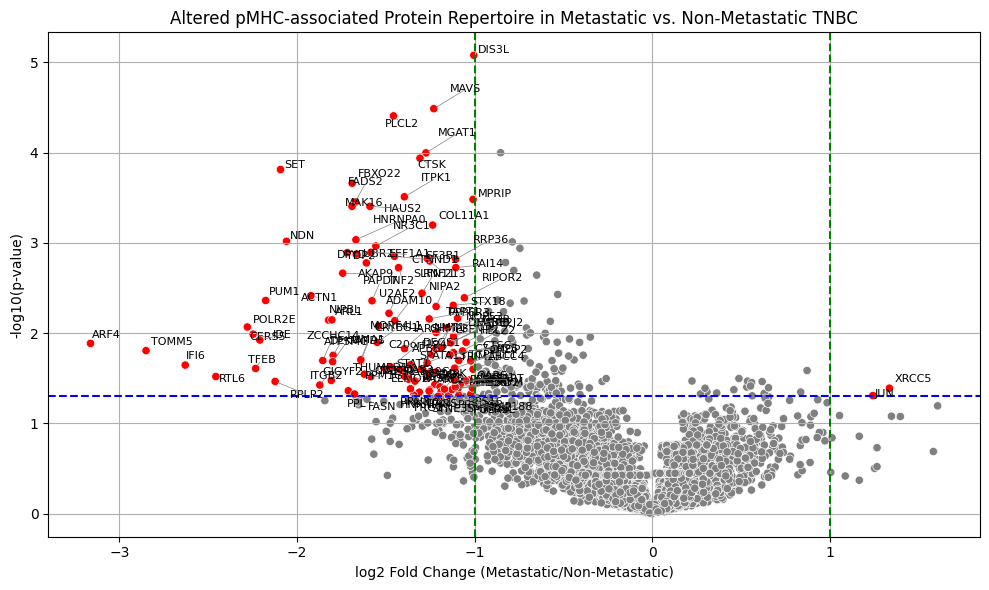

In [ ]:
significant = (volcano_df['pval'] < 0.051) & (abs(volcano_df['log2FC']) > 1)
from adjustText import adjust_text

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volcano_df,
    x='log2FC', y='-log10pval',
    hue=(volcano_df['pval'] < 0.05) & (abs(volcano_df['log2FC']) > 1),
    palette={True: 'red', False: 'gray'},
    legend=False
)

texts = []
for protein in volcano_df[significant].index:
    x = volcano_df.loc[protein, 'log2FC']
    y = volcano_df.loc[protein, '-log10pval']
    texts.append(plt.text(x, y, protein, fontsize=8))

# Automatically adjust label positions
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    force_text=1.2,     # Increase label-label repulsion
    force_points=1.2)   # Increase point-label repulsion

plt.axhline(-np.log10(0.05), color='blue', linestyle='--')
plt.axvline(1, color='green', linestyle='--')
plt.axvline(-1, color='green', linestyle='--')

plt.title('Altered pMHC-associated Protein Repertoire in Metastatic vs. Non-Metastatic TNBC')
plt.xlabel('log2 Fold Change (Metastatic/Non-Metastatic)')
plt.ylabel('-log10(p-value)')
plt.grid(True)
plt.tight_layout()
plt.show()


27 [-0.13746998  0.1290869 ]
41 [ 0.6001777 -0.6780872]


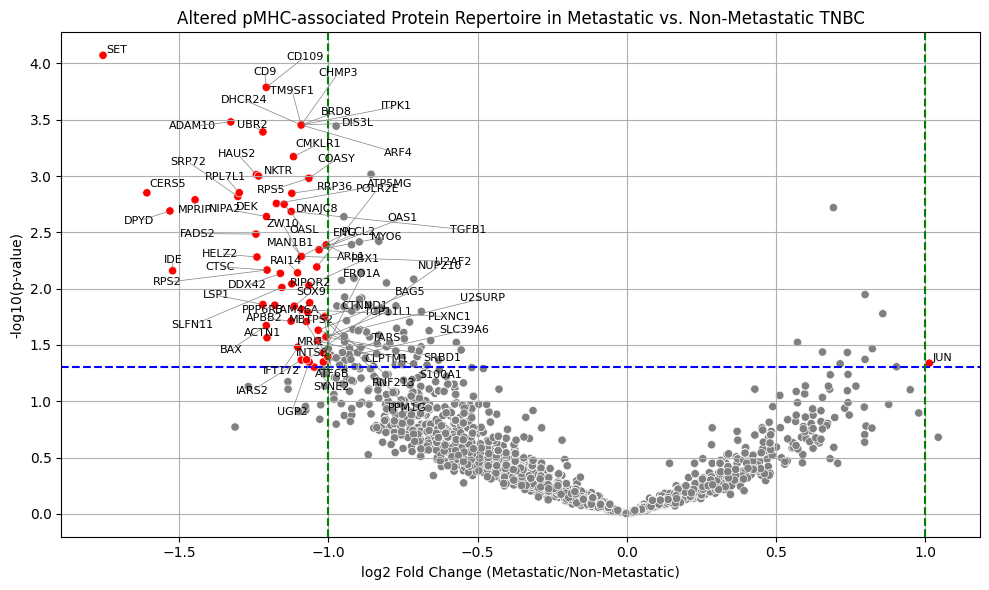

In [ ]:
significant = (volcano_df_count['pval'] < 0.051) & (abs(volcano_df_count['log2FC']) > 1)
from adjustText import adjust_text

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volcano_df_count,
    x='log2FC', y='-log10pval',
    hue=(volcano_df_count['pval'] < 0.05) & (abs(volcano_df_count['log2FC']) > 1),
    palette={True: 'red', False: 'gray'},
    legend=False
)

texts = []
for protein in volcano_df_count[significant].index:
    x = volcano_df_count.loc[protein, 'log2FC']
    y = volcano_df_count.loc[protein, '-log10pval']
    texts.append(plt.text(x, y, protein, fontsize=8))

# Automatically adjust label positions
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    force_text=1.2,     # Increase label-label repulsion
    force_points=1.2)   # Increase point-label repulsion

plt.axhline(-np.log10(0.05), color='blue', linestyle='--')
plt.axvline(1, color='green', linestyle='--')
plt.axvline(-1, color='green', linestyle='--')

plt.title('Altered pMHC-associated Protein Repertoire in Metastatic vs. Non-Metastatic TNBC')
plt.xlabel('log2 Fold Change (Metastatic/Non-Metastatic)')
plt.ylabel('-log10(p-value)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
volcano_df_count.loc['PCBD1']

,PCBD1
log2FC,0.623716
-log10pval,0.875894
pval,0.133078


In [ ]:
every_protein_detected_df_count.loc['PCBD1']

,PCBD1
Sample_333,1.000000
Sample_2339,1.000000
Sample_977,1.000000
Sample_825,1.000000
Sample_2060,1.584963
Sample_1097,1.000000
Sample_1949,0.000000
Sample_2189,0.000000
Sample_513,0.000000
Sample_1478,0.000000


# **Signal intensity distribution per sample QC**

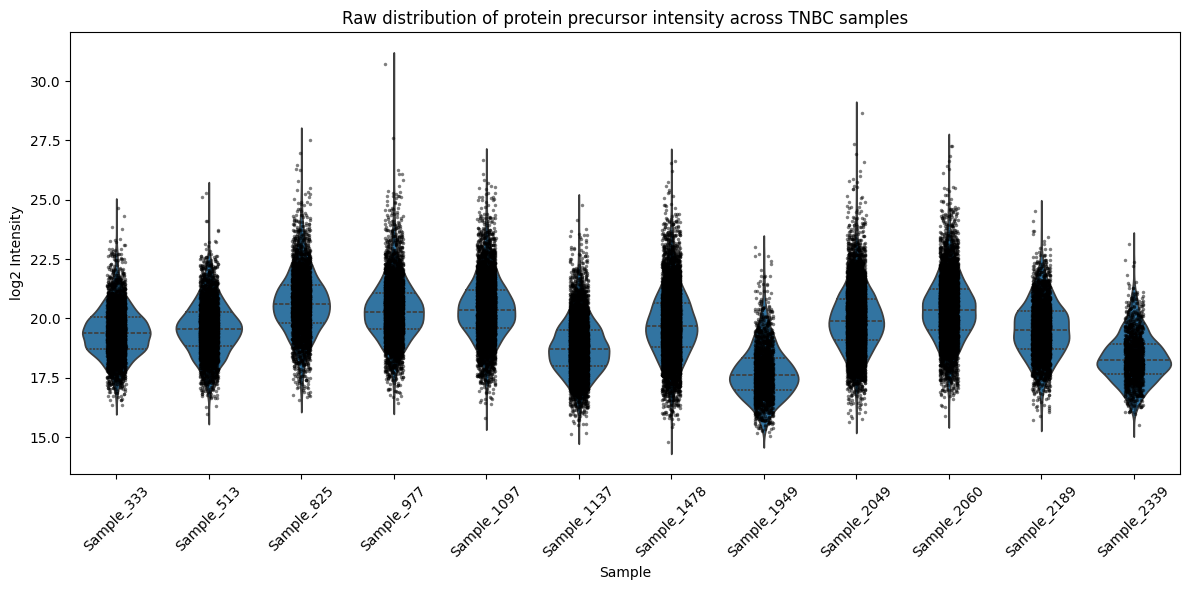

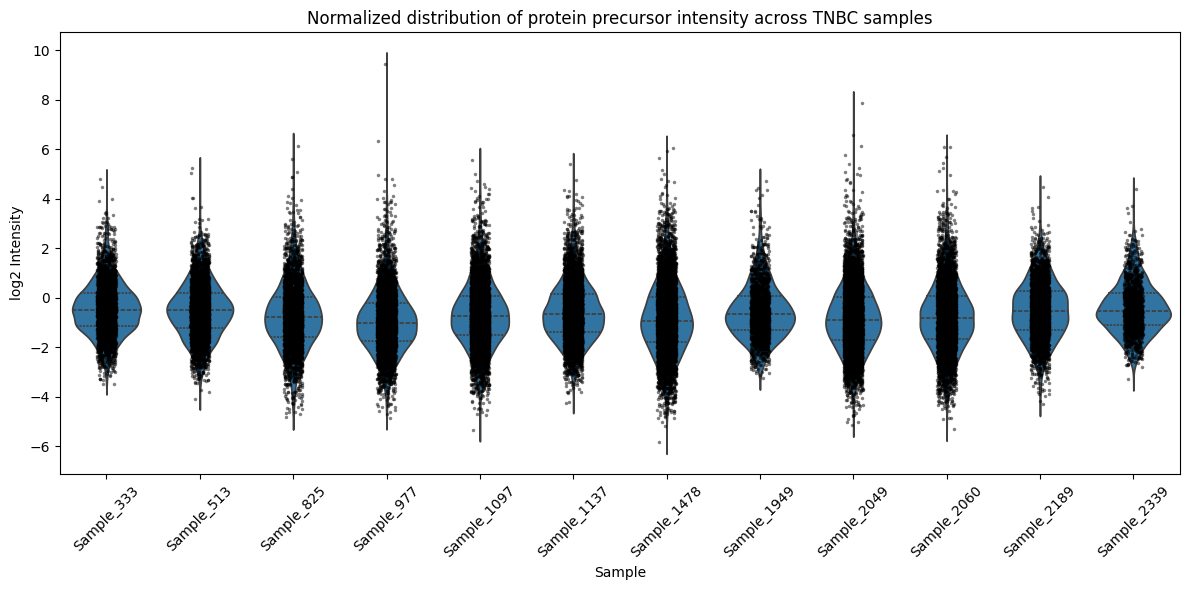

In [ ]:
## QC of Signal Intensity distribution per sample samples


# Create a flat list of (sample label, value) tuples

combined_data = pd.DataFrame([
    {'Sample': sample_label, 'Value': value}
    for sample_label, df in all_samples.items()
    for value in df['Total ion current']
])

combined_data['Value'] = np.log2(combined_data['Value'])

normalized_data = pd.DataFrame([
    {'Sample': sample_label, 'Value': value/df['Total ion current'].mean()}
    for sample_label, df in all_samples.items()
    for value in df['Total ion current']
])

normalized_data['Value'] = np.log2(normalized_data['Value'])

filtered_data_pre_norm = combined_data[combined_data['Sample'].isin(N_spread_labels+NLN_spread_labels)]
filtered_data_post_norm = normalized_data[normalized_data['Sample'].isin(N_spread_labels+NLN_spread_labels)]


plt.figure(figsize=(12, 6))
sns.violinplot(x='Sample', y='Value', data=filtered_data_pre_norm, inner='quartile')
sns.stripplot(x='Sample', y='Value', data=filtered_data_pre_norm, dodge = True, color='k', size=2.5, alpha=0.5, jitter=True)
plt.title("Raw distribution of protein precursor intensity across TNBC samples")
plt.xlabel("Sample")
plt.ylabel("log2 Intensity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 6))
sns.violinplot(x='Sample', y='Value', data=filtered_data_post_norm, inner='quartile')
sns.stripplot(x='Sample', y='Value', data=filtered_data_post_norm, dodge = True, color='k', size=2.5, alpha=0.5, jitter=True)
plt.title("Normalized distribution of protein precursor intensity across TNBC samples")
plt.xlabel("Sample")
plt.ylabel("log2 Intensity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
